# Imports, evironment, setting some variables

In [18]:
import numpy as np
from copy import copy
import os

### set to single GPU

In [19]:
# this will pin your CUDA to GPU 0. Using a single GPU is a best practice right now because:
# 1) there's a known bug in NRSS simulation engine that will segfault every 1000 runs or something if you parallelize across energy (NRSS default)
# (we can't seem to find what's doing it), and
# 2) it keeps the other GPUs open for others to use 
# you can check GPU usage with nvidia-smi from command prompt. This will tell you if someone is on GPU 0, and you could choose another from "0","1","2".

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

### arguments for eventual function

In [20]:
#specify arguments for model generation
args_default = {}
args_default["ld"] = 1024
args_default["vd"] = 512
args_default["radius_nm"] = 17
args_default["PhysSize_nm_per_voxel"] = 0.5
args_default["S0"] = 0.5
args_default["S_slope_per_nm"] = -0.02

args_default["energies"] = np.array([260, 270])
args_default["energies"] = np.append(args_default["energies"], np.arange(275, 283, 1), axis=0)
args_default["energies"] = np.append(args_default["energies"], np.arange(283, 291, 0.1), axis=0)
args_default["energies"] = np.append(args_default["energies"], np.arange(291, 305, 1), axis=0)

args = copy(args_default)

<div class="alert alert-block alert-info"><b>Tip:</b> Ultimately it makes sense to wrap the morphology generation in a function. I like to have a single argument to that function that is a Python dictionary with keyed entries for each of the necessary features. There are plenty of other ways to set this up, including a special data class for the argument, or individual arguments for each of the parameters.</div>

# Import indexes of refraction for polymers and SiO2

A lot of scientific thought and understanding should go into your indices of refraction. They strongly affect the results of the NRSS simulations.

The index of refraction is an abstract representation of your concept of how the molecule exists inits nanoscale space. It is expressed as the complex index of refraction:<br>
$n = 1 - \delta -i\beta$,<br> which includes β, the absorptive part that is specifically scaled NEXAFS absorption (directly convertible to Beer-Lambert extinction coefficient) and can be understood with NEXAFS transition dipole moments, and δ, the dispersive part, which is calculated from β but has less direct interpretability with respect to NEXAFS concepts.

NRSS uses anisotropic soft X-ray indices of refraction that are <i>uniaxial</i>, meaning they have two distinct optical axes. The preferred nomenclature is one <u>extraordinary</u> (sometimes "Para") optical axis that describes one of the three spatial dimensions and one <u>ordinary</u> (sometimes "Perp") optical axis that describes the other two directions. It should be noted that we chose uniaxial constants primarily for convenience to facilitate model building and data size constraints; in rare cases it can be an oversimplification. It should be noted that the NRSS has a (currently complicated) workaround that would allow us to express a biaxial (3 unique optical axes) index of refraction should one be necessary.

The first step in developing an index of refraction is to choose an orientation of the molecule within this frame. Which axis would be aligned with the ordinary, and which with the extraordinary? With NRSS simulations of polymer chains, it is typical to choose the chain long axis as the extraordinary direction and develop the index of refraction such that the long axis is perfectly parallel to the extraordinary direction. But there are situations where we make other choices. In semiconducting polymers, for example, the backbone is ribbon like, and we frequently choose the 1s→π* transition dipole vector (ribbon plane normal) as extraordinary. There's no set practice or even recommended best practice; the choice depends on the specific challenge.

The use of a uniaxial function assumes that the two ordinary directions are reasonably symmetrical such that they are both described well by the same optical constants. From a single molecule perspective, perfect symmetry is unlikely, but the optical constants are meant to represent an <i>ensemble</i> of molecules within a voxel (think: with an ensemble of rotations about the extraordinary axis), and within that ensemble, more symmetries are possible. 

It is also important to understand that a single anisotropic index of refraction assumes a specific <i>conformation</i> or family of conformations as well. This is expressed in the relative preferred directions of different bond-level resonances, and the relative strengths of those preferences. Some of the relationships are rigid and fixed, like the relationship between the C-O 1s→σ* transition dipole vector and its C=O 1s→π* transition dipole vector; they both originate from the same bond and are always exactly orthogonal. Consider, however, the relationship between polymer backbone C-C 1s→σ* transition dipole vectors and those belonging to a pendant group such as the phenyl of polystyrene or the carboxylate of polymethylmethacrylate. In those cases, the relative orientation of bonds belonging to the pendant groups and those belonging to the backbone may vary depending on the molecular conformation. Developing these relationships can be one of the more challenging aspects of index of refraction development. There are multiple approaches, including measuring the native anisotropy of polymers in thin films (if they exhibit any), fitting and labeling spectra and then manipulating relative bond intensities to fit a certain conformational picture, performing atomistic molecular simulations to determine a likely conformational ensemble and then manipulating the spectra, or calculating biaxial spectra from a rigid molecular frame using DFT.

To sumamrize, the index of refraction assumes:
1) a molecular orientation or ensemble of orientation relative to the extraordinary and ordinary directions
2) symmetry with the molecule or ensemble in the ordinary axes of the index of refraction
3) a specific conformation or ensemble of conformations for molecules with conformational freedom

An underlying principle here is that the resonant excitations of NEXAFS and RSoXS are <u>individual bond level</u>, not whole-molecule or even moiety-level. When we speak of moiety-level behaviors, we are either making an assumption about conformation or we are treating a rigid moiety such as a phenyl ring or the 3-atom carboxylate assembly, where the bond relationships are fixed.


In [21]:
from pandas import read_csv
# note I sometimes use pandas for handling tabular data, but it's more common on the team to deal with xarray ( which is like "pandas for scientists") 
# or (more elementary) numpy arrays
from NRSS.morphology import OpticalConstants
# note this part of NRSS is a simple interpolator that will interpolate the index of refraction to the specific chosen energies

# although we currently store these in text files, it's a bad idea and there is a lot of itnerest on the team for making a database that holds indices of refraction
ps_uni = read_csv("PS_anisotropic_milner_July2024.txt", sep=",")
pmma_uni = read_csv("pmma_dan.txt", sep=" ")
# note in the plot below that the oxygen edge doesn't have any fine stucture or differences between Para and Perp
# TODO: craft a pmma uniaxial dielectric function valid at the oxygen edge
sio2_uni = read_csv("siox_iso_NIST_Jan2024.txt", sep=",")

args["oc_polymer"] = OpticalConstants.calc_constants(args["energies"], ps_uni, name="PS")
args["oc_particle"] = OpticalConstants.calc_constants(args["energies"], sio2_uni, name="SiO2")


<Axes: title={'center': 'SiO2'}, xlabel='Energy'>

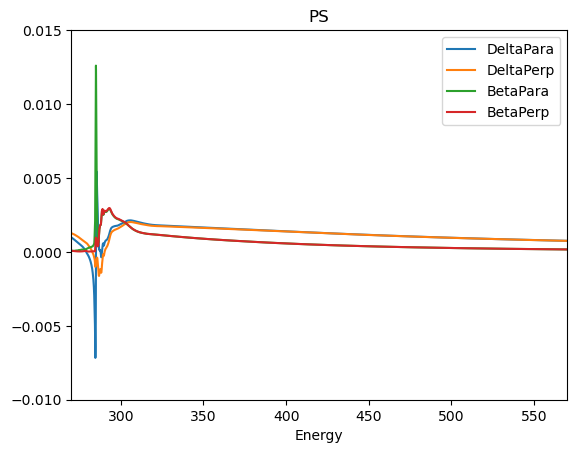

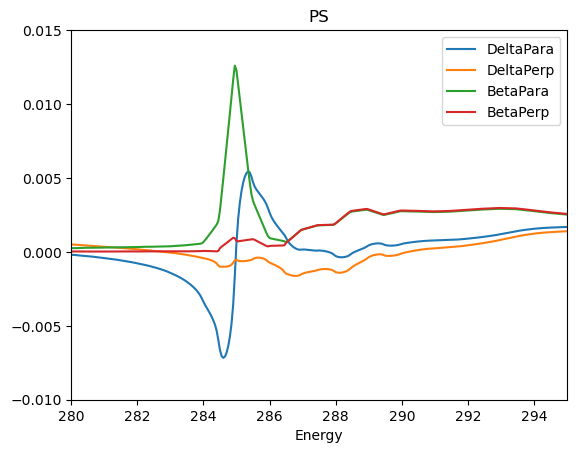

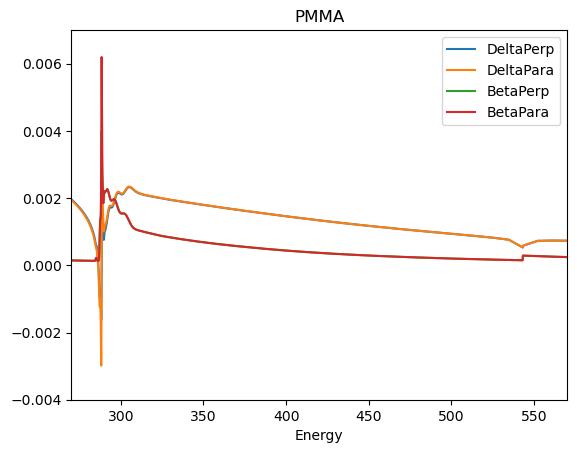

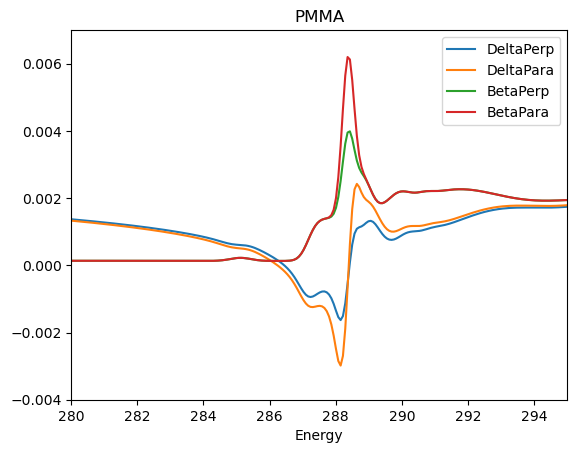

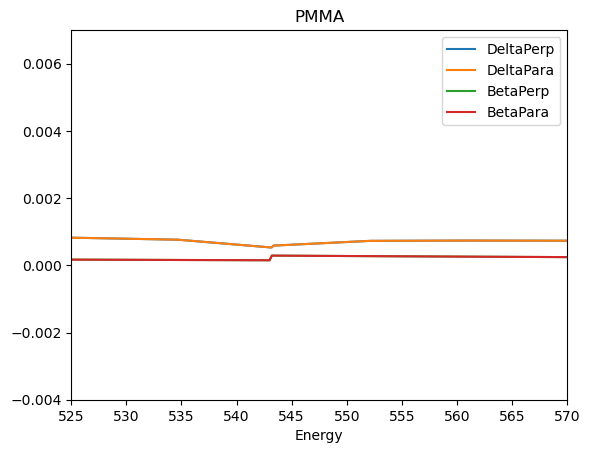

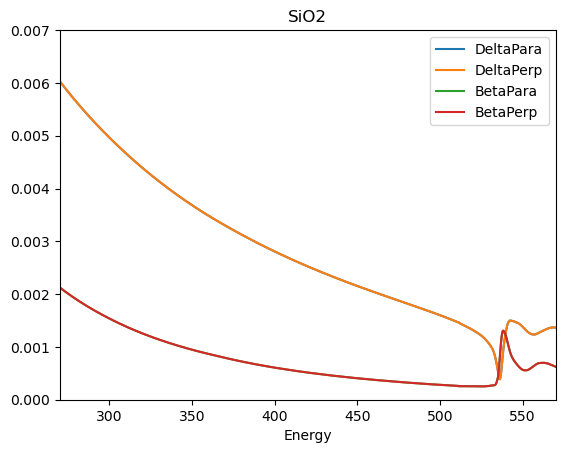

In [22]:
ps_uni.plot(x="Energy", xlim = (270,570), ylim = (-.01,0.015), title = "PS")
ps_uni.plot(x="Energy", xlim = (280,295), ylim = (-.01,0.015), title = "PS")

pmma_uni.plot(x="Energy", xlim = (270,570), ylim = (-.004,0.007), title = "PMMA")
pmma_uni.plot(x="Energy", xlim = (280,295), ylim = (-.004,0.007), title = "PMMA")
pmma_uni.plot(x="Energy", xlim = (525,570), ylim = (-.004,0.007), title = "PMMA")


sio2_uni.plot(x="Energy", xlim = (270,570), ylim = (0,0.007), title = "SiO2")

<div class="alert alert-block alert-success"><b>Important:</b> Always look at the indices of refraction you're feeding in, and understand every aspect of them. Our team has sometimes had issues that boiled down to the index being different than they thought it was.
</div>

<div class="alert alert-block alert-warning">
<b>Caution:</b> The PMMA dielectric function above lacks anisotropic fine structure at oxygen. It needs a bit more work.
</div><br>

# Model construction, step by step 

This section describes how to make a "parametric cartoon" model from scratch. The behavior of the model will be controlled by a handful of adjustable parameters. I sometimes call these "parametric cartoons." More sophisticated models can be made with NRSS using data fusion ideas, incorporating data from other sources, perhaps in combination with parametric cartoon ideas, to craft something more complex that is consistent with other measurements by other principles.

The most common starting point for a parametric cartoon morphology is to create a grid and perform math on it to make the morphology. In this case, our goal is to create a single spherical particle in the middle of the simulation volume and surround it with adsorbed polymer. The polymer will have orientation fields described by Euler angles and an extent of orientation described by "S," an orientational order parameter. Although in much conventional usage, S varies between +1 and -0.5, in our usage, we confine it to between 1 and 0, within which range it is mathematically identical to the volume fraction of "perfectly oriented" material that is combined with (1-S) fraction of isotropic material.

## build grid

We will use the numpy (np) library extensively. One powerful approach to crafting the grid is to use the np.ogrid operator. It essentially creates a skeleton grid filled with values that match the indices in which they are stored. Note that the vertical dimension args["vd"] here is default 512 and the lateral dimensions args["ld"] is 1024; the resultant creations are thus very large objects in memory.

Also, it is important to emphasize that NRSS models use an index order of ZYX in array indexing. That explains the specific order of the ogrid call.

In [23]:
z,y,x = np.ogrid[0:args["vd"], 0:args["ld"], 0:args["ld"]]

<div class="alert alert-block alert-info"><b>Tip:</b> np.mgrid also works for this.</div>

<div class="alert alert-block alert-info"><b>Tip:</b> Sometimes we will make morphologies using GPU when the contruction algorithm is slow. A common library we use is cupy, which is a GPU replacement for numpy.</div>


## build spherical particle

We can then calculate the distance of each voxel in the 512x1024x1024 array from the array center using the pythagorean theorem:

In [24]:
dist_from_ctr = np.sqrt((x - x.mean()) ** 2 + (y - y.mean()) ** 2 + (z - z.mean()) ** 2)

...and the nanoparticle is then described by everything less than the radius away from center. This is a boolean operation that will make v_sphere a boolean 512x1024x1024 array of True where there is nanoparticle and False where there is not.

In [25]:
v_sphere = dist_from_ctr < args["radius_nm"] / args["PhysSize_nm_per_voxel"]

Visualization of the nanoparticle:

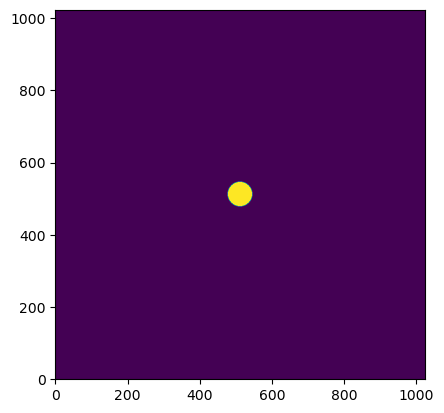

In [26]:
from matplotlib import pyplot as plt
plt.imshow(v_sphere[255], origin = 'lower')


<div class="alert alert-block alert-info"><b>Tip:</b> Note that the imshow default has the origin in the upper left. The reason it does this is that that is the convention for how photographs and other images must displayed. This default has caused all sorts of misunderstandings as to what is where. origin = 'lower' puts the origin in the bottom right. </div>


## calculate euler angles

The gifs below explain our Euler angle convention. There are a broad number of conventions with Euler angles. They are convenient, but can be confusing.

We use the "zyz" Euler convention, which means explicit rotations about the z axis, followed by the y axis, followed by the z axis again. Do not confuse these with intrinsic Euler rotations, where the rotations occur about the already-rotated axis. In our Euler angles, the axes are fixed in the morphology frame.

Because our ansitropic index of refraction is uniaxial and the two ordinary directions identical, the first Euler rotation phi has no effect on the result, and it isn't included in our model. We thus will only concern our calculations with finding theta and psi.

Historically, our group and others have been challenged with getting these Euler angles correct. When they are wrong, they are often catastrophically wrong. It is absolutely necessary to use the built-in visualization capability of the NRSS to check that the Euler angles you coded are the ones you intended.

<style>
    .white {
        background-color: #FFFFFF;
        color: #000000;
    }
</style>
<div class="white">
    <span>NRSS ZYZ Euler Angle Visualization - Long Format</span>
    <img src="Euler_ZYZ-v4.gif" alt="Euler Long">
    <br>
    <span>NRSS ZYZ Euler Angle Visualization - Short Format</span>
    <img src="Euler_ZYZ-v2.gif" alt="Euler Short">

</div>


<div class="alert alert-block alert-info"><b>Tip:</b> There are very many Euler angle conventions out there and all have the same basic idea but rotate on different sequences and have differences in extrinsic vs. intrinsic.</div>


### Radial Euler Angles

We will start by calculating Euler angles for the radial case, then manipulate them for different kinds of tangential. Radial is described by the vector starting at the sphere origin and ending on a specific voxel. We will use trigonmetric functions to calculate the angles.

In [27]:
# start by determining the delta between the voxel location and the center of the sphere
delta_x = x - args["ld"] / 2
delta_y = y - args["ld"] / 2
delta_z = z - args["vd"] / 2

psi = np.arctan2(delta_y, delta_x) + 0*delta_z
# note that the 0*delta_z makes the psi field 3D - this is due to our use of ogrid and its interaction with numpy broadcasting

theta = np.arctan2(np.sqrt(delta_x ** 2 + delta_y ** 2), delta_z)

Text(0.5, 1.0, 'psi for radial')

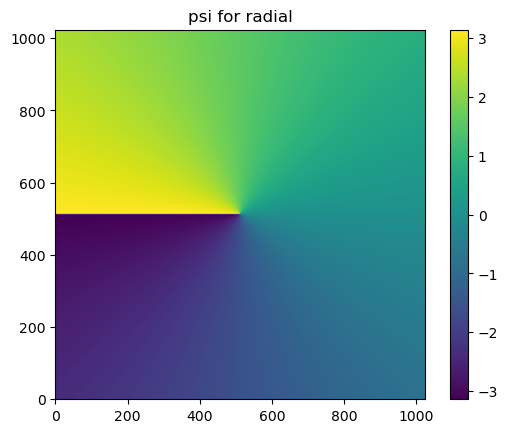

In [28]:
fig, ax = plt.subplots()
img = ax.imshow(psi[255], origin = 'lower')
fig.colorbar(img)
ax.set_title("psi for radial")

<div class="alert alert-block alert-info"><b>Tip:</b> Graphs like this are where it's important to have origin='lower'. Although this kind of plotting can be helpful while determining model construction algorithm, the "gold standard" visualization after the model is constructed is the only one you should fully trust. </div>


Text(0.5, 1.0, 'psi for radial')

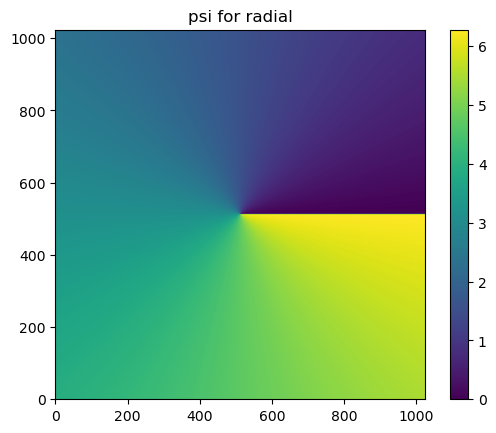

In [29]:
fig, ax = plt.subplots()
img = ax.imshow(psi[255] % (2 * np.pi), origin = 'lower')
fig.colorbar(img)
ax.set_title("psi for radial")

Text(0.5, 1.0, 'theta for radial')

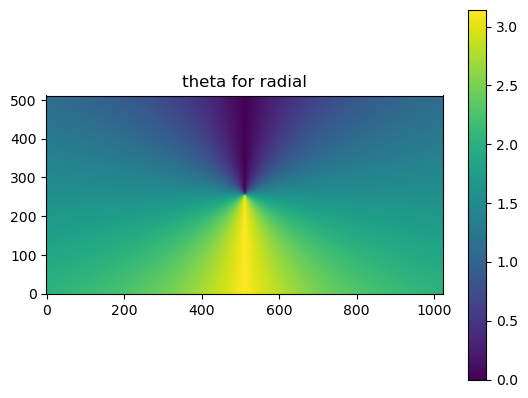

In [30]:
fig, ax = plt.subplots()
img = ax.imshow(theta[:,:,512], origin = 'lower')
fig.colorbar(img)
ax.set_title("theta for radial")

### Tagential in two styles 

There are advanced versions of these transforms that use scipy.spatial.transform.Rotation library, but they are slow as molasses and it's challenging to determine how to speed them up. Instead, we'll just use trig again.

<style>
    .white {
        background-color: #FFFFFF;
        color: #000000;
    }
</style>
<div class="white">
    <span>The globe with latitude and longitude</span>
    <img src="globe.gif" alt="Globe">

</div>


#### Latitude-Style Tangential

In [31]:
# for latitude - style tangential, theta = pi/2 everywhere and psi = psi_radial - pi/2
theta_tangential_lat = np.full_like(theta, np.pi / 2)
psi_tangential_lat = psi - np.pi / 2

Text(0.5, 1.0, 'psi for tangential latitude')

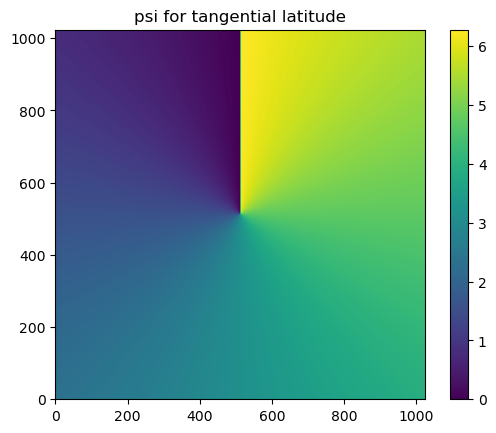

In [32]:
fig, ax = plt.subplots()
img = ax.imshow(psi_tangential_lat[255] % (2 * np.pi), origin = 'lower')
fig.colorbar(img)
ax.set_title("psi for tangential latitude")

Text(0.5, 1.0, 'theta for tangential latitude')

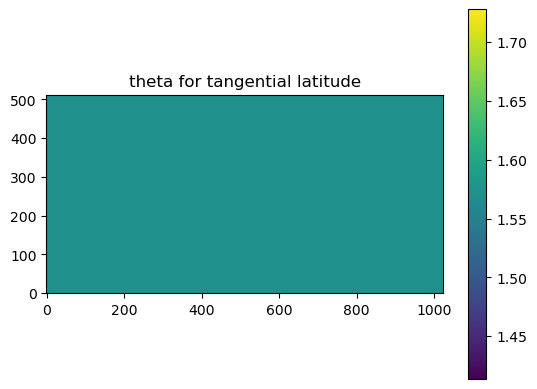

In [33]:
fig, ax = plt.subplots()
img = ax.imshow(theta_tangential_lat[:,:,512], origin = 'lower')
fig.colorbar(img)
ax.set_title("theta for tangential latitude")

#### Longitude-Style Tangential

In [34]:
# for longitude-style tangential, psi = psi_radial, and theta is adjusted to be either theta_radial + pi/2 or theta_radial-pi/2
psi_tangential_lon = psi
theta_tangential_lon = np.where(theta < np.pi / 2, theta + np.pi / 2, theta - np.pi / 2)


Text(0.5, 1.0, 'theta for tangential longitude')

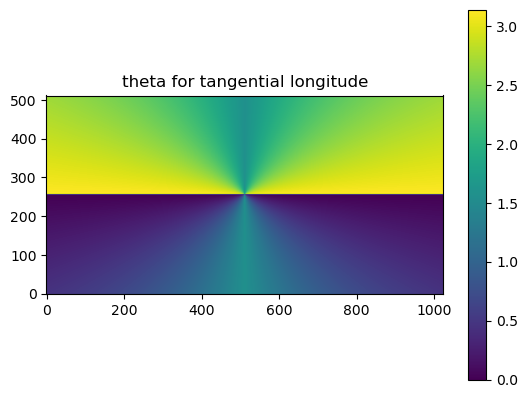

In [35]:
fig, ax = plt.subplots()
img = ax.imshow(theta_tangential_lon[:,:,512], origin = 'lower')
fig.colorbar(img)
ax.set_title("theta for tangential longitude")

## Orientation magnitude in polymer

We will start with a linear decay. It's defined by an intercept (S0) and a slope (S_slope_per_nm). The distance away from center can be used to calculate it. but we'll subtract the radius from it to make it the distance from the hard / soft boundary. Therefore S0 will be the orientation immediately adjacent to the boundary.

In [36]:
S_field = args["S0"] + (dist_from_ctr - args["radius_nm"] / args["PhysSize_nm_per_voxel"])*args["S_slope_per_nm"]

In [37]:
S_field.min()

-14.163334057498716

In [38]:
# S cannot be les than 0
S_field = np.maximum(0, S_field)
# S cannot be greater than S0
S_field = np.minimum(args["S0"], S_field)
#although it doesn't really affect the model calculation, there should be no S where there is particle
S_field *= (v_sphere == False)

Text(0.5, 1.0, 'theta for radial')

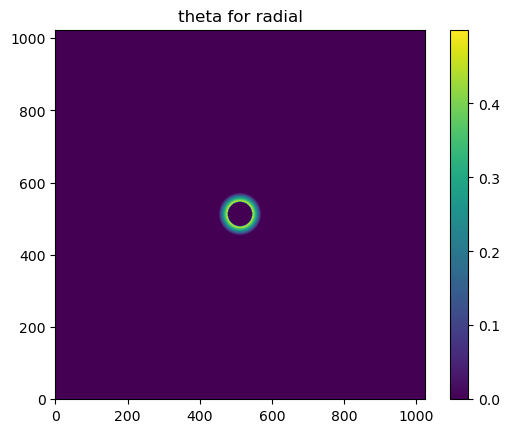

In [39]:
fig, ax = plt.subplots()
img = ax.imshow(S_field[255,:,:], origin = 'lower')
fig.colorbar(img)
ax.set_title("theta for radial")

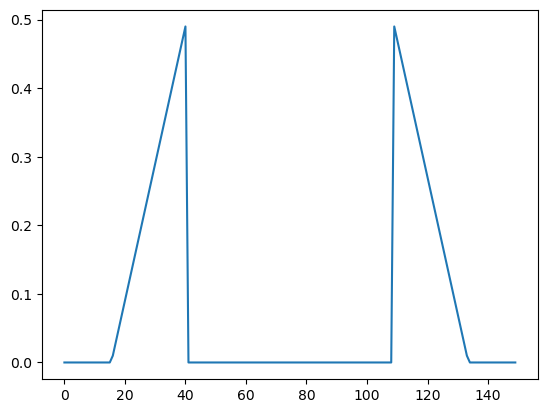

In [40]:
plt.plot(S_field[255, 512, 512-75:512+75])

# Running the model: Radial case

## Composing material and morphology objects

Below we compose the morphology, which is an object built from some number of material objects. Most of the fields are fairly self-explanatory. It is important to include a correct PhysSize here, and in general one of the places people get tripped up is translating back-and-forth between voxels and nm. In this case, we considered PhysSize above when applying other arguments, so we should be good.

Notice I force everything to be dtype=np.float32. This is probably not essential, but it's a habit of mine to ensure no issues with the simulation engine. It is possible to create the parametric cartoon using faster calculations with 16-bit numbers, which I frequently do. Also note that numpy has moved its default in recent versions to 64-bit, so slower and more accurate. The "correct" way to handle this is to set dtype when you create the fields like the ogrid, and have the correct type propagate through. This way using astype also works, but it's slower and more RAM intensive because it creates a new copy of each array and ensures it's float32.

In [41]:
# compose morphology
# we will start with the radial one

from NRSS.morphology import Material, Morphology

a_zeros = np.zeros(v_sphere.shape, dtype=np.float32)

mat1_poly = Material(
    materialID=1,
    Vfrac = (1-v_sphere).astype(np.float32), 
    S=S_field.astype(np.float32),
    theta=theta.astype(np.float32),
    psi=psi.astype(np.float32),
    NumZYX=v_sphere.shape,
    energies=args["energies"],
    opt_constants=args["oc_polymer"].opt_constants,
    name="polymer",
)

mat2_particle = Material(
    materialID=2,
    Vfrac=v_sphere.astype(np.float32),
    S=a_zeros,
    theta=a_zeros,
    psi=a_zeros,
    NumZYX=v_sphere.shape, 
    energies=args["energies"],
    opt_constants=args["oc_particle"].opt_constants,    
    name="particle",
)

morph = Morphology(
    2,
    {1: mat1_poly, 2: mat2_particle},
    PhysSize=args["PhysSize_nm_per_voxel"],
)

<div class="alert alert-block alert-info"><b>Tip:</b> Note how the args object is used here for much of the information. This foreshadows how we will assemble this code into a single function.</div>


## Visualizing radial Model

Below is our essential visualizer. I would advise to become accustomed to reading its outputs, particularly the colored graphs for volume fraction, S, and especially the Euler angles. Unfortunately, it currently can only do a horizontal slice through the model (fixed z coordinate), so it can be challenging to see if theta is displayed correctly in z. One way to handle this is to do multiple visualizer slices at different z. 

Dataset dimensions (Z, Y, X): 512 x 1024 x 1024
Number of Materials: 2

Material 1 Vfrac. Min: 0.0 Max: 1.0
Material 1 S. Min: 0.0 Max: 0.49977943301200867
Material 1 theta. Min: 0.0 Max: 3.1415927410125732
Material 1 psi. Min: -3.1396396160125732 Max: 3.1415927410125732


/homes/deand/NRSS/NRSS/visualizer.py:152: UserWarning: Visualization expects theta to have bounds of [0,pi]. This model has theta outside those bounds and visualization may be incorrect.
  warnings.warn(


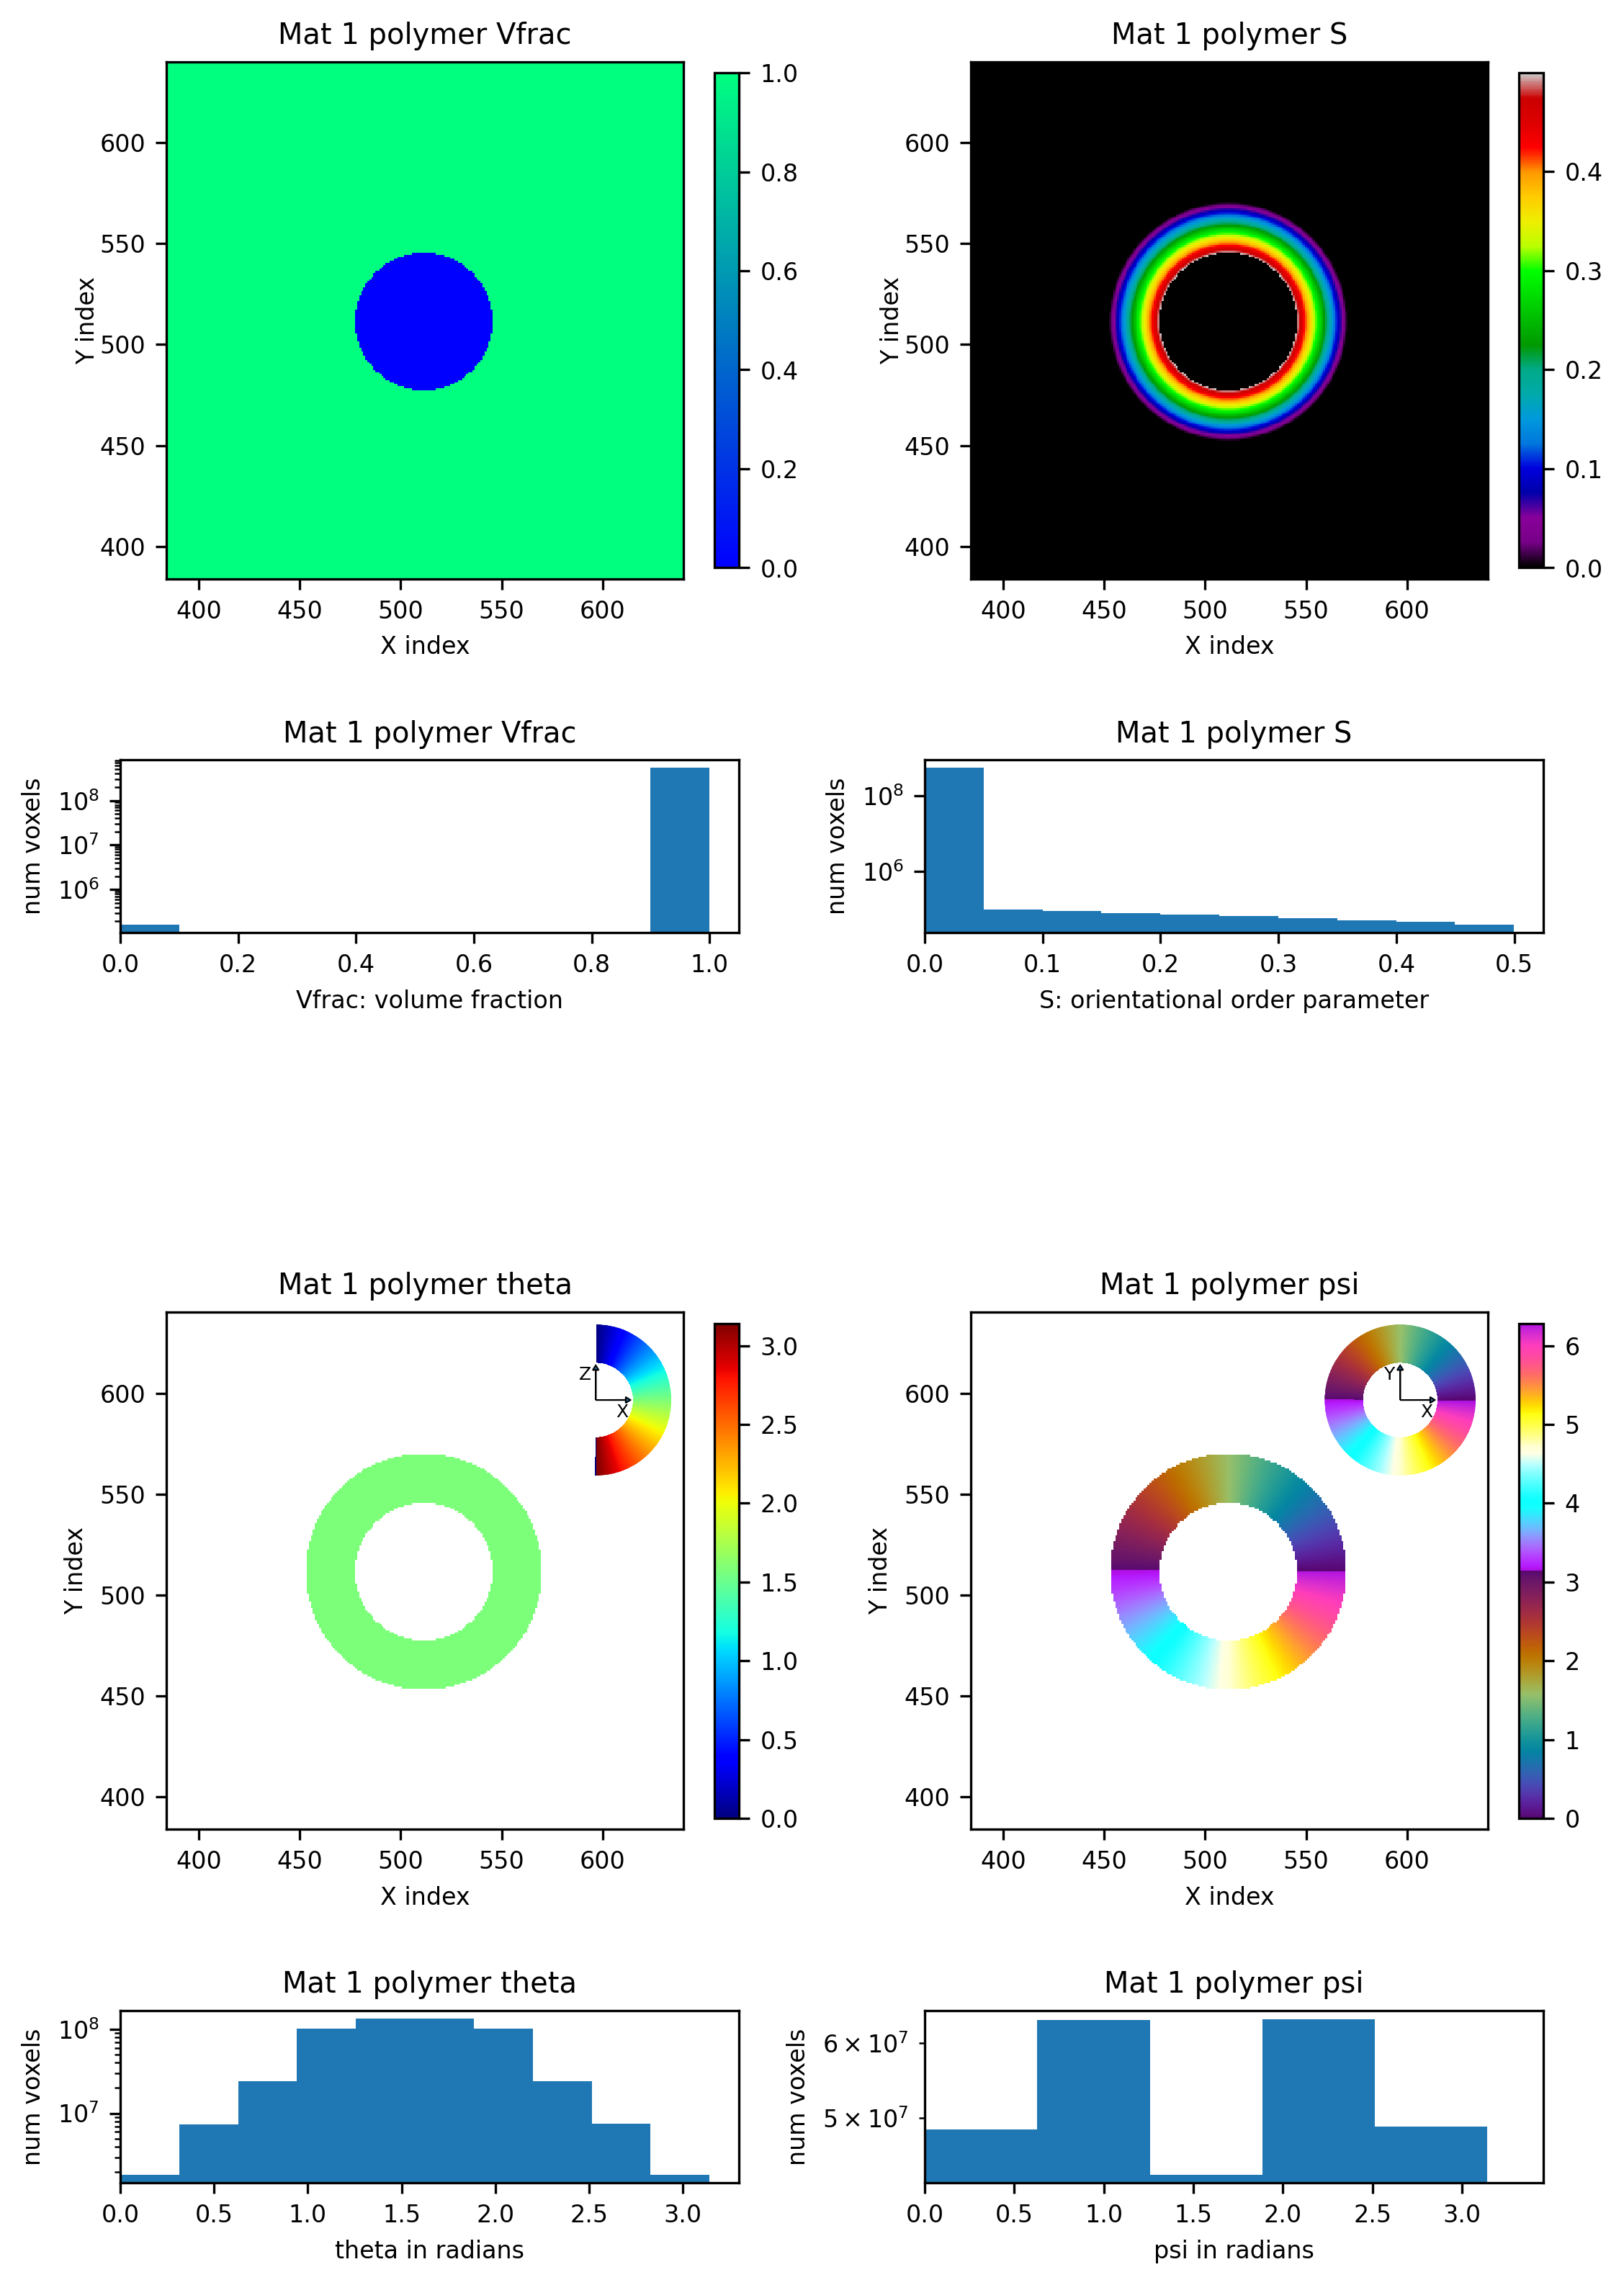

Material 2 Vfrac. Min: 0.0 Max: 1.0
Material 2 S. Min: 0.0 Max: 0.0
Material 2 theta. Min: 0.0 Max: 0.0
Material 2 psi. Min: 0.0 Max: 0.0


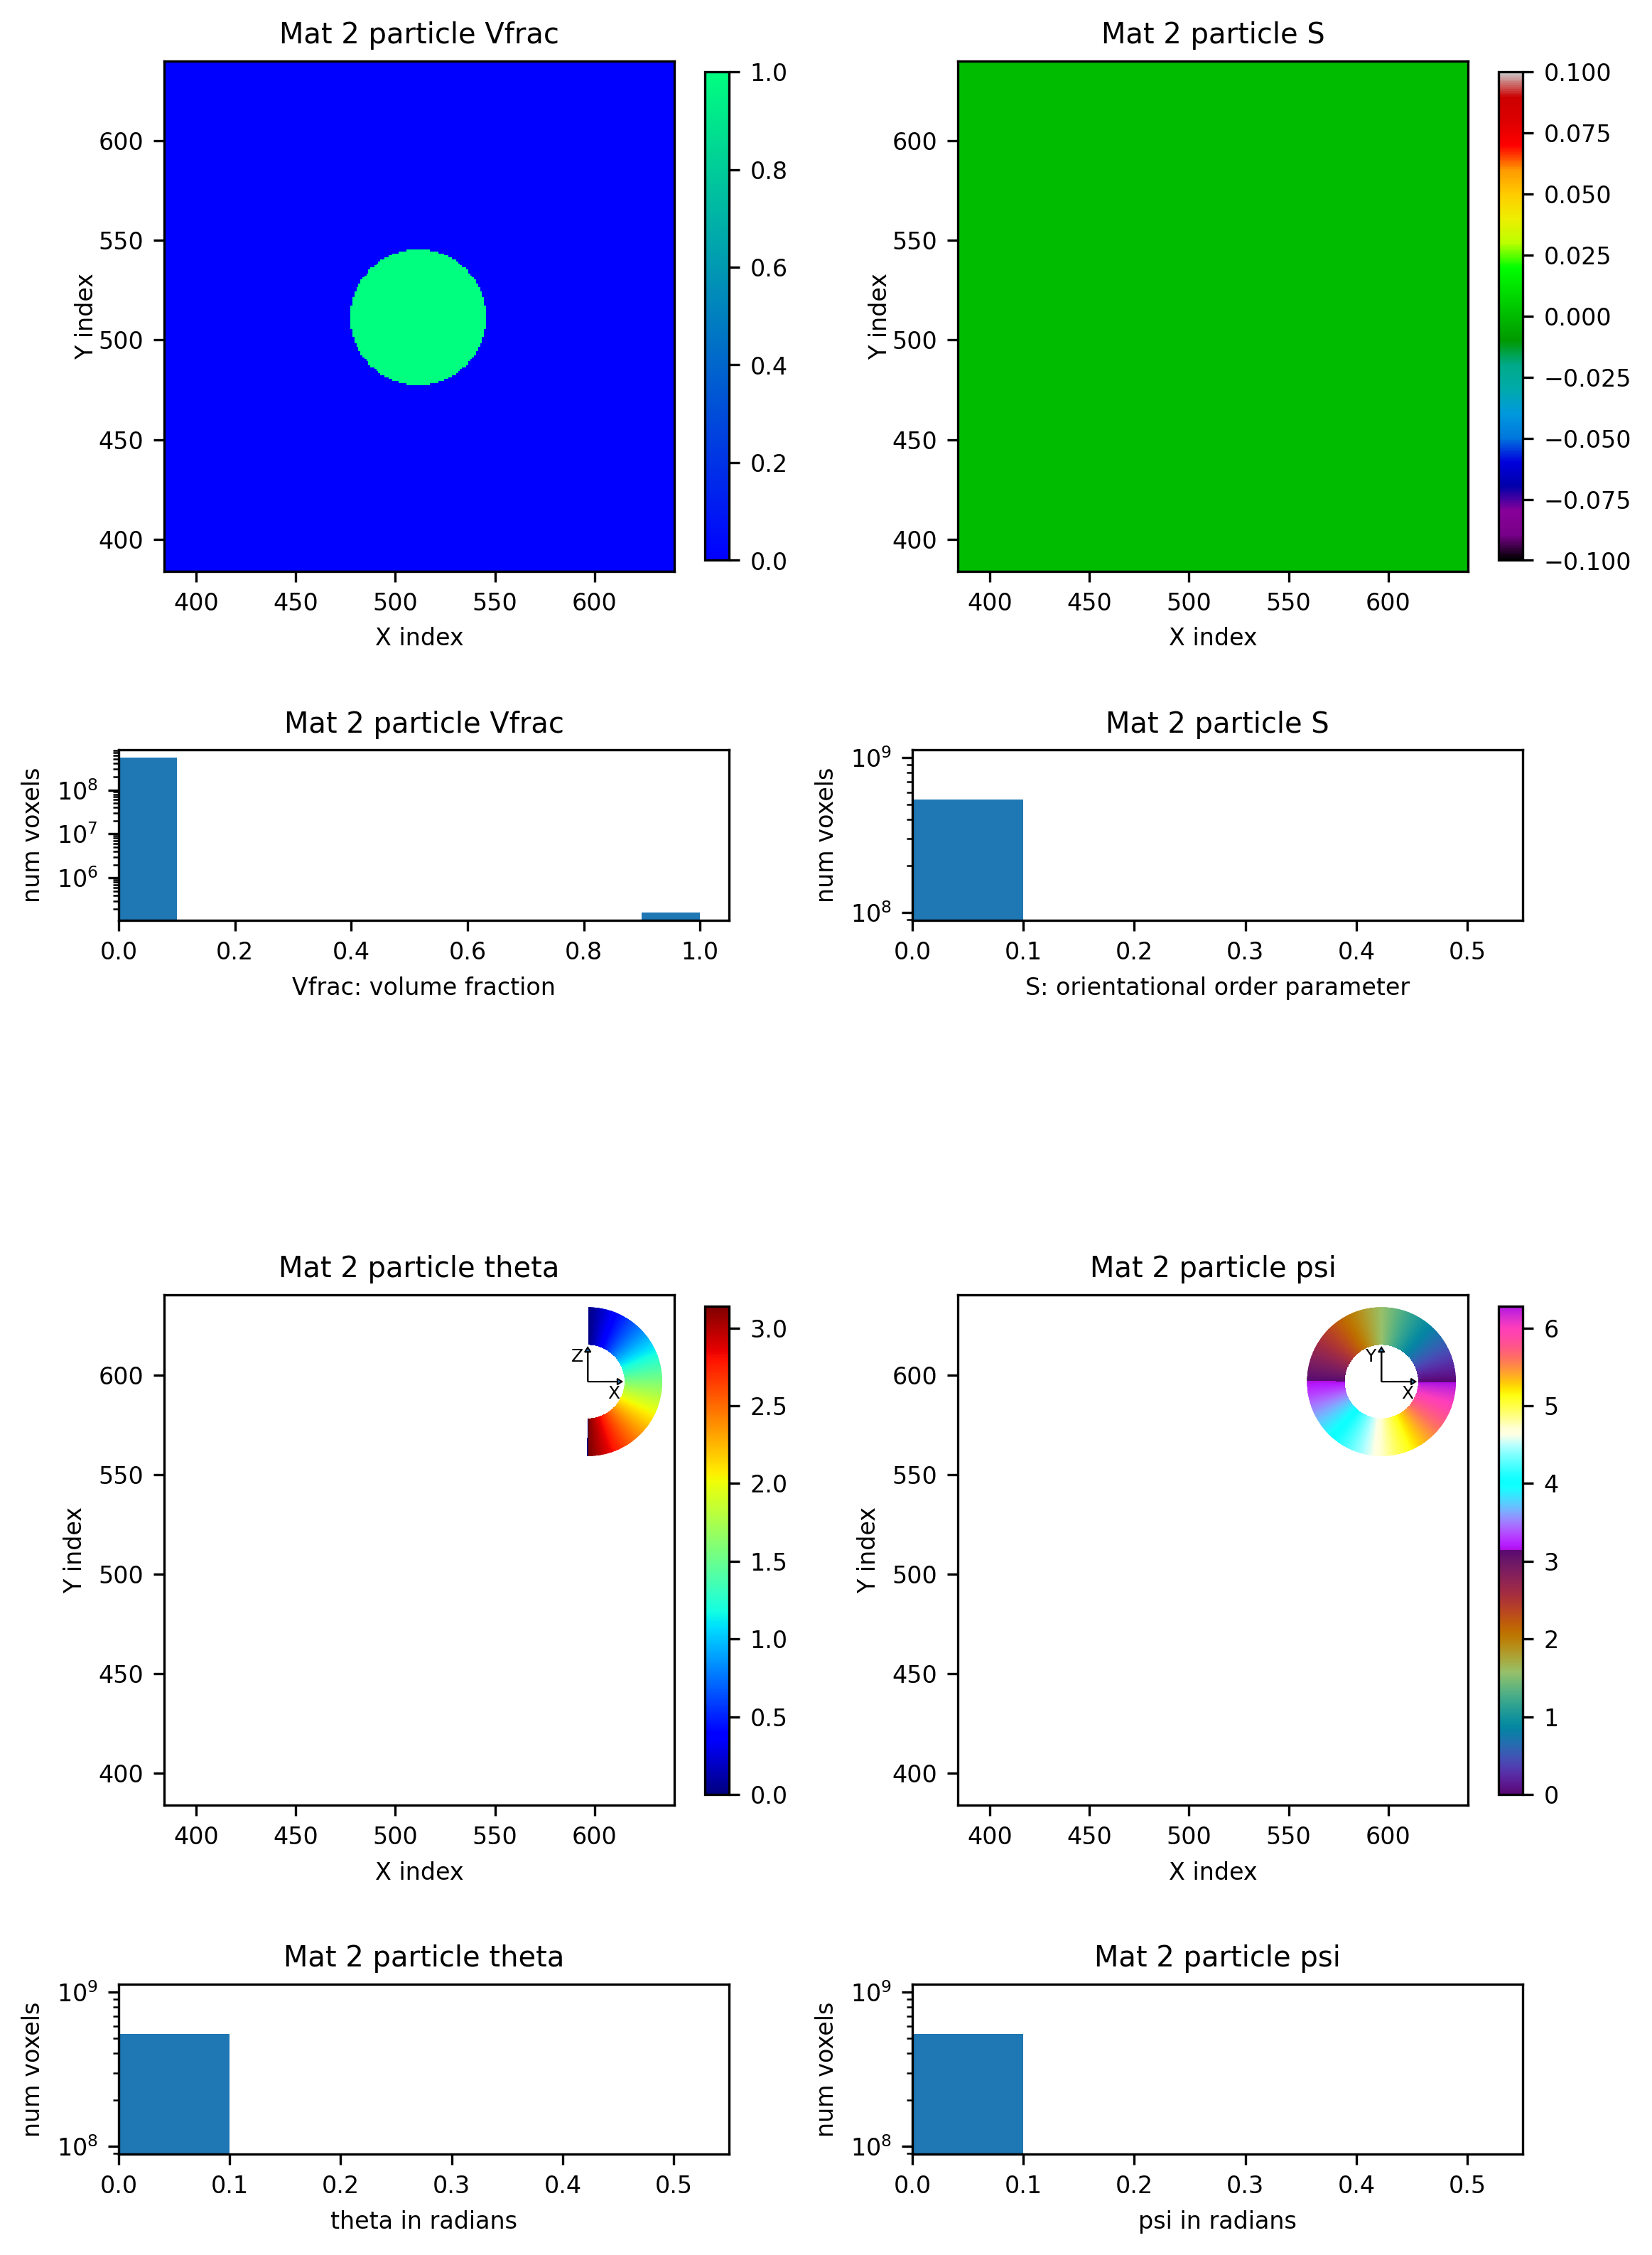

[]

<Figure size 640x480 with 0 Axes>

In [42]:
#always visualize your morphology and understand psi, theta colorwheels
morph.visualize_materials(z_slice = args["vd"]//2, subsample = 256)

In [43]:
#always visualize your morphology and understand psi, theta colorwheels
subsample = 32
quiver_psi = morph.visualize_materials(z_slice = args["vd"]//2, subsample = subsample, outputmat = [1], outputplot = ["psi"], add_quiver = True, quiver_bw = "True", runquiet = True, translate_x = subsample//1.3, translate_y = subsample//1.3)[0]
plt.imshow(quiver_psi)
plt.gca().axis("off")

<div class="alert alert-block alert-info"><b>Tip:</b> Quiver plot needs extremely high magnification to be able to see the little lines.</div>


## Running Radial Model

The model is done!

The commands below will run the model and import its data.

In [ ]:
from PyHyperScattering.integrate import WPIntegrator

# a parameter that affects how edges are handled. If set to 0, you imply perfect periodic boundary conditions. This radial model has that, but many other models do not.
morph.inputData.windowingType = 0  # cy.FFTWindowing.Hanning

# a parameter that simulates a noninteracting ensemble of differently rotated clones of the same morphology. 
# This causes pattern smoothing at the expense of significantly increased computation time
# This model is radially symmetric, so in principle at least it needs to smoothing like this.
# [start, step, end] all in degrees. The number of steps are the number of clones and will increase computation time linearly
# [0, 0, 0] will be fast but noisy,
# [0,30,180] will capture most of what you need even if not radially symmetric
# [0,1,180] is for publication-quality 2D pattern simulation of non-radially-symmetric models
morph.EAngleRotation = [0.0, 0.0, 0.0]

# this runs a little validator on the model. It will return issues if there are any
morph.validate_all(quiet=False)

#this actually runs the model
data = morph.run(stdout=True, stderr=False)

# this is part of PyHyperScattering, which we also use for analyzing experintally-collected data
integrator = WPIntegrator(use_chunked_processing=False)
remeshed_data = integrator.integrateImageStack(data)
I = remeshed_data.mean(dim="chi")


All material checks have passed
All objects have been validated successfully. You can run your simulation

 [STAT] Executing: 

Number of CUDA devices:1
[INFO] [GPU = Quadro RTX 8000] : 260eV -> 304eV
 [STAT] Energy = 260 starting 
 [STAT] Energy = 270 starting 
 [STAT] Energy = 275 starting 
 [STAT] Energy = 276 starting 
 [STAT] Energy = 277 starting 
 [STAT] Energy = 278 starting 
 [STAT] Energy = 279 starting 
 [STAT] Energy = 280 starting 
 [STAT] Energy = 281 starting 
 [STAT] Energy = 282 starting 
 [STAT] Energy = 283 starting 
 [STAT] Energy = 283.1 starting 
 [STAT] Energy = 283.2 starting 
 [STAT] Energy = 283.3 starting 
 [STAT] Energy = 283.4 starting 
 [STAT] Energy = 283.5 starting 
 [STAT] Energy = 283.6 starting 
 [STAT] Energy = 283.7 starting 
 [STAT] Energy = 283.8 starting 
 [STAT] Energy = 283.9 starting 
 [STAT] Energy = 284 starting 
 [STAT] Energy = 284.1 starting 
 [STAT] Energy = 284.2 starting 
 [STAT] Energy = 284.3 starting 
 [STAT] Energy = 284.4 starting

  0%|          | 0/104 [00:00<?, ?it/s]

<div class="alert alert-block alert-info"><b>Tip:</b> Note how it found only one gpu when running.</div>


## Visualizing radial simulation results

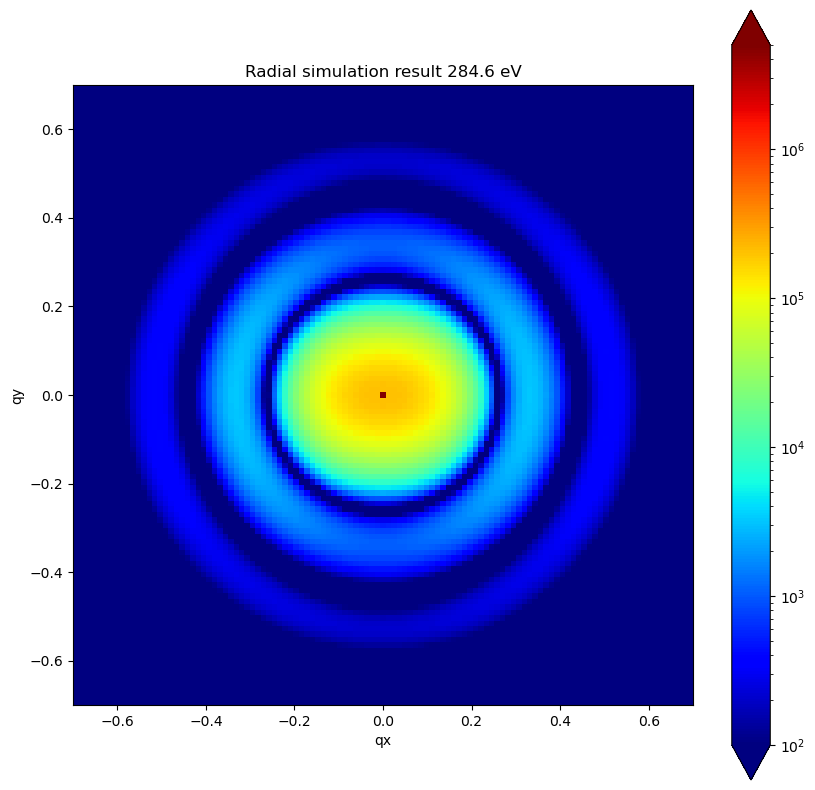

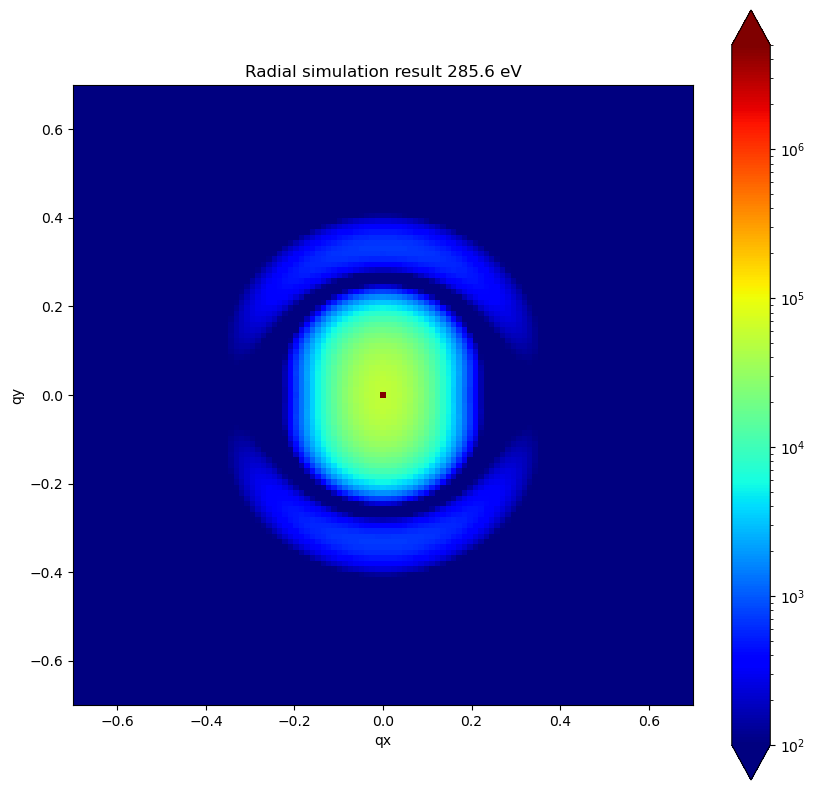

In [ ]:
import matplotlib.colors as colors

for energy in [284.6, 285.6]:
    fig, ax = plt.subplots(figsize = (10,10))
    ax.axes.set_aspect('equal')
    data.sel(energy = energy, method = 'nearest').plot(ax = ax, vmin = 1E2, vmax = 5E6, xlim = (-.7, .7), ylim = (-.7, .7), norm = colors.LogNorm(), cmap = 'jet')
    plt.title(f"Radial simulation result {energy} eV")
    plt.show()
    plt.close

<div class="alert alert-block alert-info"><b>Tip:</b> Energies above were chosen by looking for maxima in the "A" plot below.</div>


In [ ]:
A = remeshed_data.rsoxs.AR(chi_width = 45)


<div class="alert alert-block alert-info"><b>Tip:</b> When possible, it's recommended to use the built-in Anisotropic Ratio (AR) calculator in PyHyperScattering.</div>

Text(0.5, 1.0, 'Radial simulation result, A')

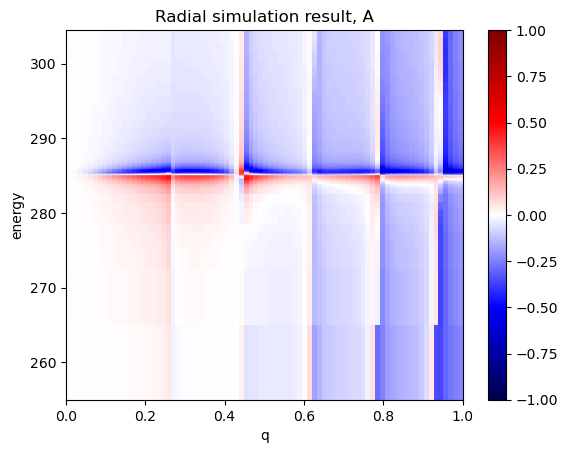

In [ ]:
A.plot(xlim=(0,1.0), vmin = -1, vmax = 1, cmap = 'seismic')
plt.title(f"Radial simulation result, A")

The result shown above is a now-"classic" result we get for polystyrene-grafted nanoparticles. You see a region of positive anisotropy at energies lower than the peak, and a region of negative anistropy at regions higher than the peak. It's similar to the result in our gold-grafted nanoparticle work:

<blockquote>Mukherjee, Subhrangsu, et al. "Polarized X-ray scattering measures molecular orientation in polymer-grafted nanoparticles." Nat. Commun., vol. 12, no. 4896, 12 Aug. 2021, pp. 1-10, <a href="https://www.nature.com/articles/s41467-021-25176-4">doi:10.1038/s41467-021-25176-4</a> .</blockquote>

...but the model in Mukherjee is different in that <br>
A) Mukherjee particles are gold, not SiO2, it does make a difference,<br>
B) Mukherjee is a multi-particle simulation. Howevever, this result and others show that a single-particle simulation is often "good enough" to understand anisotropy phenomena<br>
C) Mukherjee has a slightly different parametric cartoon<br>

Food for thought and comparison to classic SANS scattering:

Intensity in this system is going to be a <a href="https://www.sasview.org/docs/old_docs/5.0.2/user/models/sphere.html">classic spherical form factor scattering.</a> A way to think about the orientation sensitivty relative to the model in that link is that in RSoXS, sld_solvent is different in the directions parallel and perpendicular to the electric field vector. The specific orientation - radial or tangential - determines which one is higher and which one is lower.

A more advanced and relevant classic form factor is the <a href="https://www.sasview.org/docs/user/models/core_shell_sphere.html">core-shell form factor,</a> which is closer to what we're doing here since the oriented region is not the whole solvent medium. In this case, the electric field vector affects the sld_shell in a way that depends on polymer orientation and the S0 decay modulates effective shell thickness. 

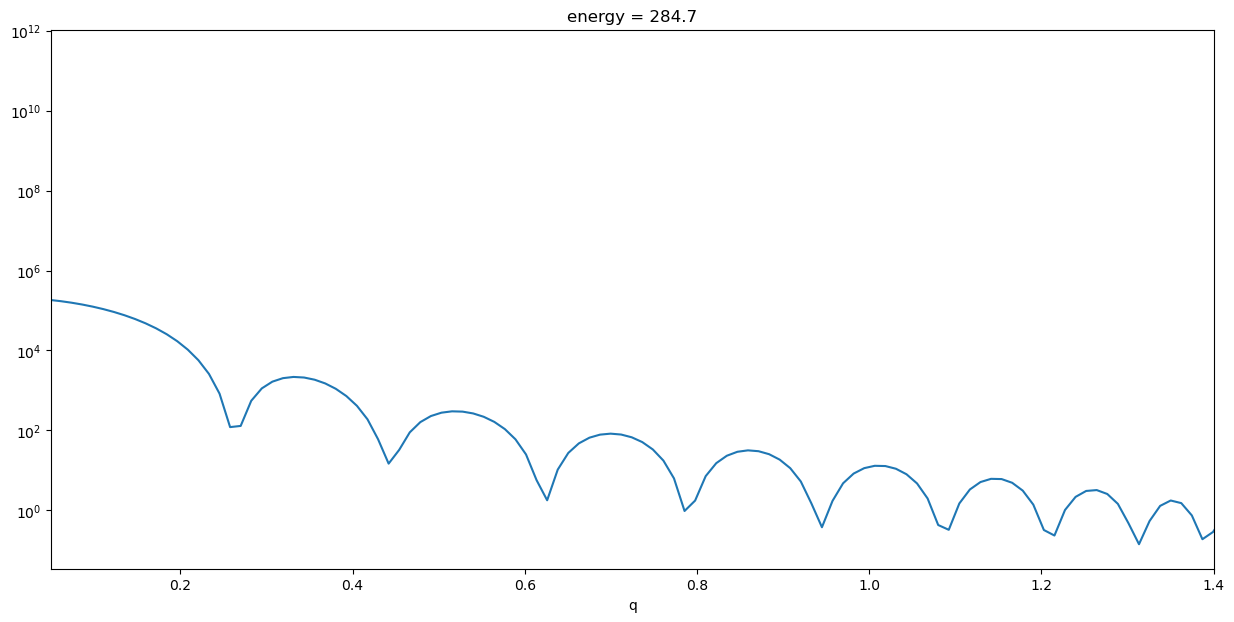

In [ ]:
fig, ax = plt.subplots(figsize = (15,7))
I.sel(energy = 284.7, method = 'nearest').plot(ax = ax, yscale = "log", xlim = (0.05, 1.4))
plt.show()

# Running the model: Latitude Tangential case

## Compose

In [ ]:
mat1_poly = Material(
    materialID=1,
    Vfrac = (1-v_sphere).astype(np.float32), 
    S=S_field.astype(np.float32),
    theta=theta_tangential_lat.astype(np.float32),
    psi=psi_tangential_lat.astype(np.float32),
    NumZYX=v_sphere.shape,
    energies=args["energies"],
    opt_constants=args["oc_polymer"].opt_constants,
    name="polymer",
)

mat2_particle = Material(
    materialID=2,
    Vfrac=v_sphere.astype(np.float32),
    S=a_zeros,
    theta=a_zeros,
    psi=a_zeros,
    NumZYX=v_sphere.shape, 
    energies=args["energies"],
    opt_constants=args["oc_particle"].opt_constants,    
    name="particle",
)

morph = Morphology(
    2,
    {1: mat1_poly, 2: mat2_particle},
    PhysSize=args["PhysSize_nm_per_voxel"],
)

## Visualize

Dataset dimensions (Z, Y, X): 512 x 1024 x 1024
Number of Materials: 2

Material 1 Vfrac. Min: 0.0 Max: 1.0
Material 1 S. Min: 0.0 Max: 0.5
Material 1 theta. Min: 1.5707963705062866 Max: 1.5707963705062866
Material 1 psi. Min: -4.71043586730957 Max: 1.5707963705062866


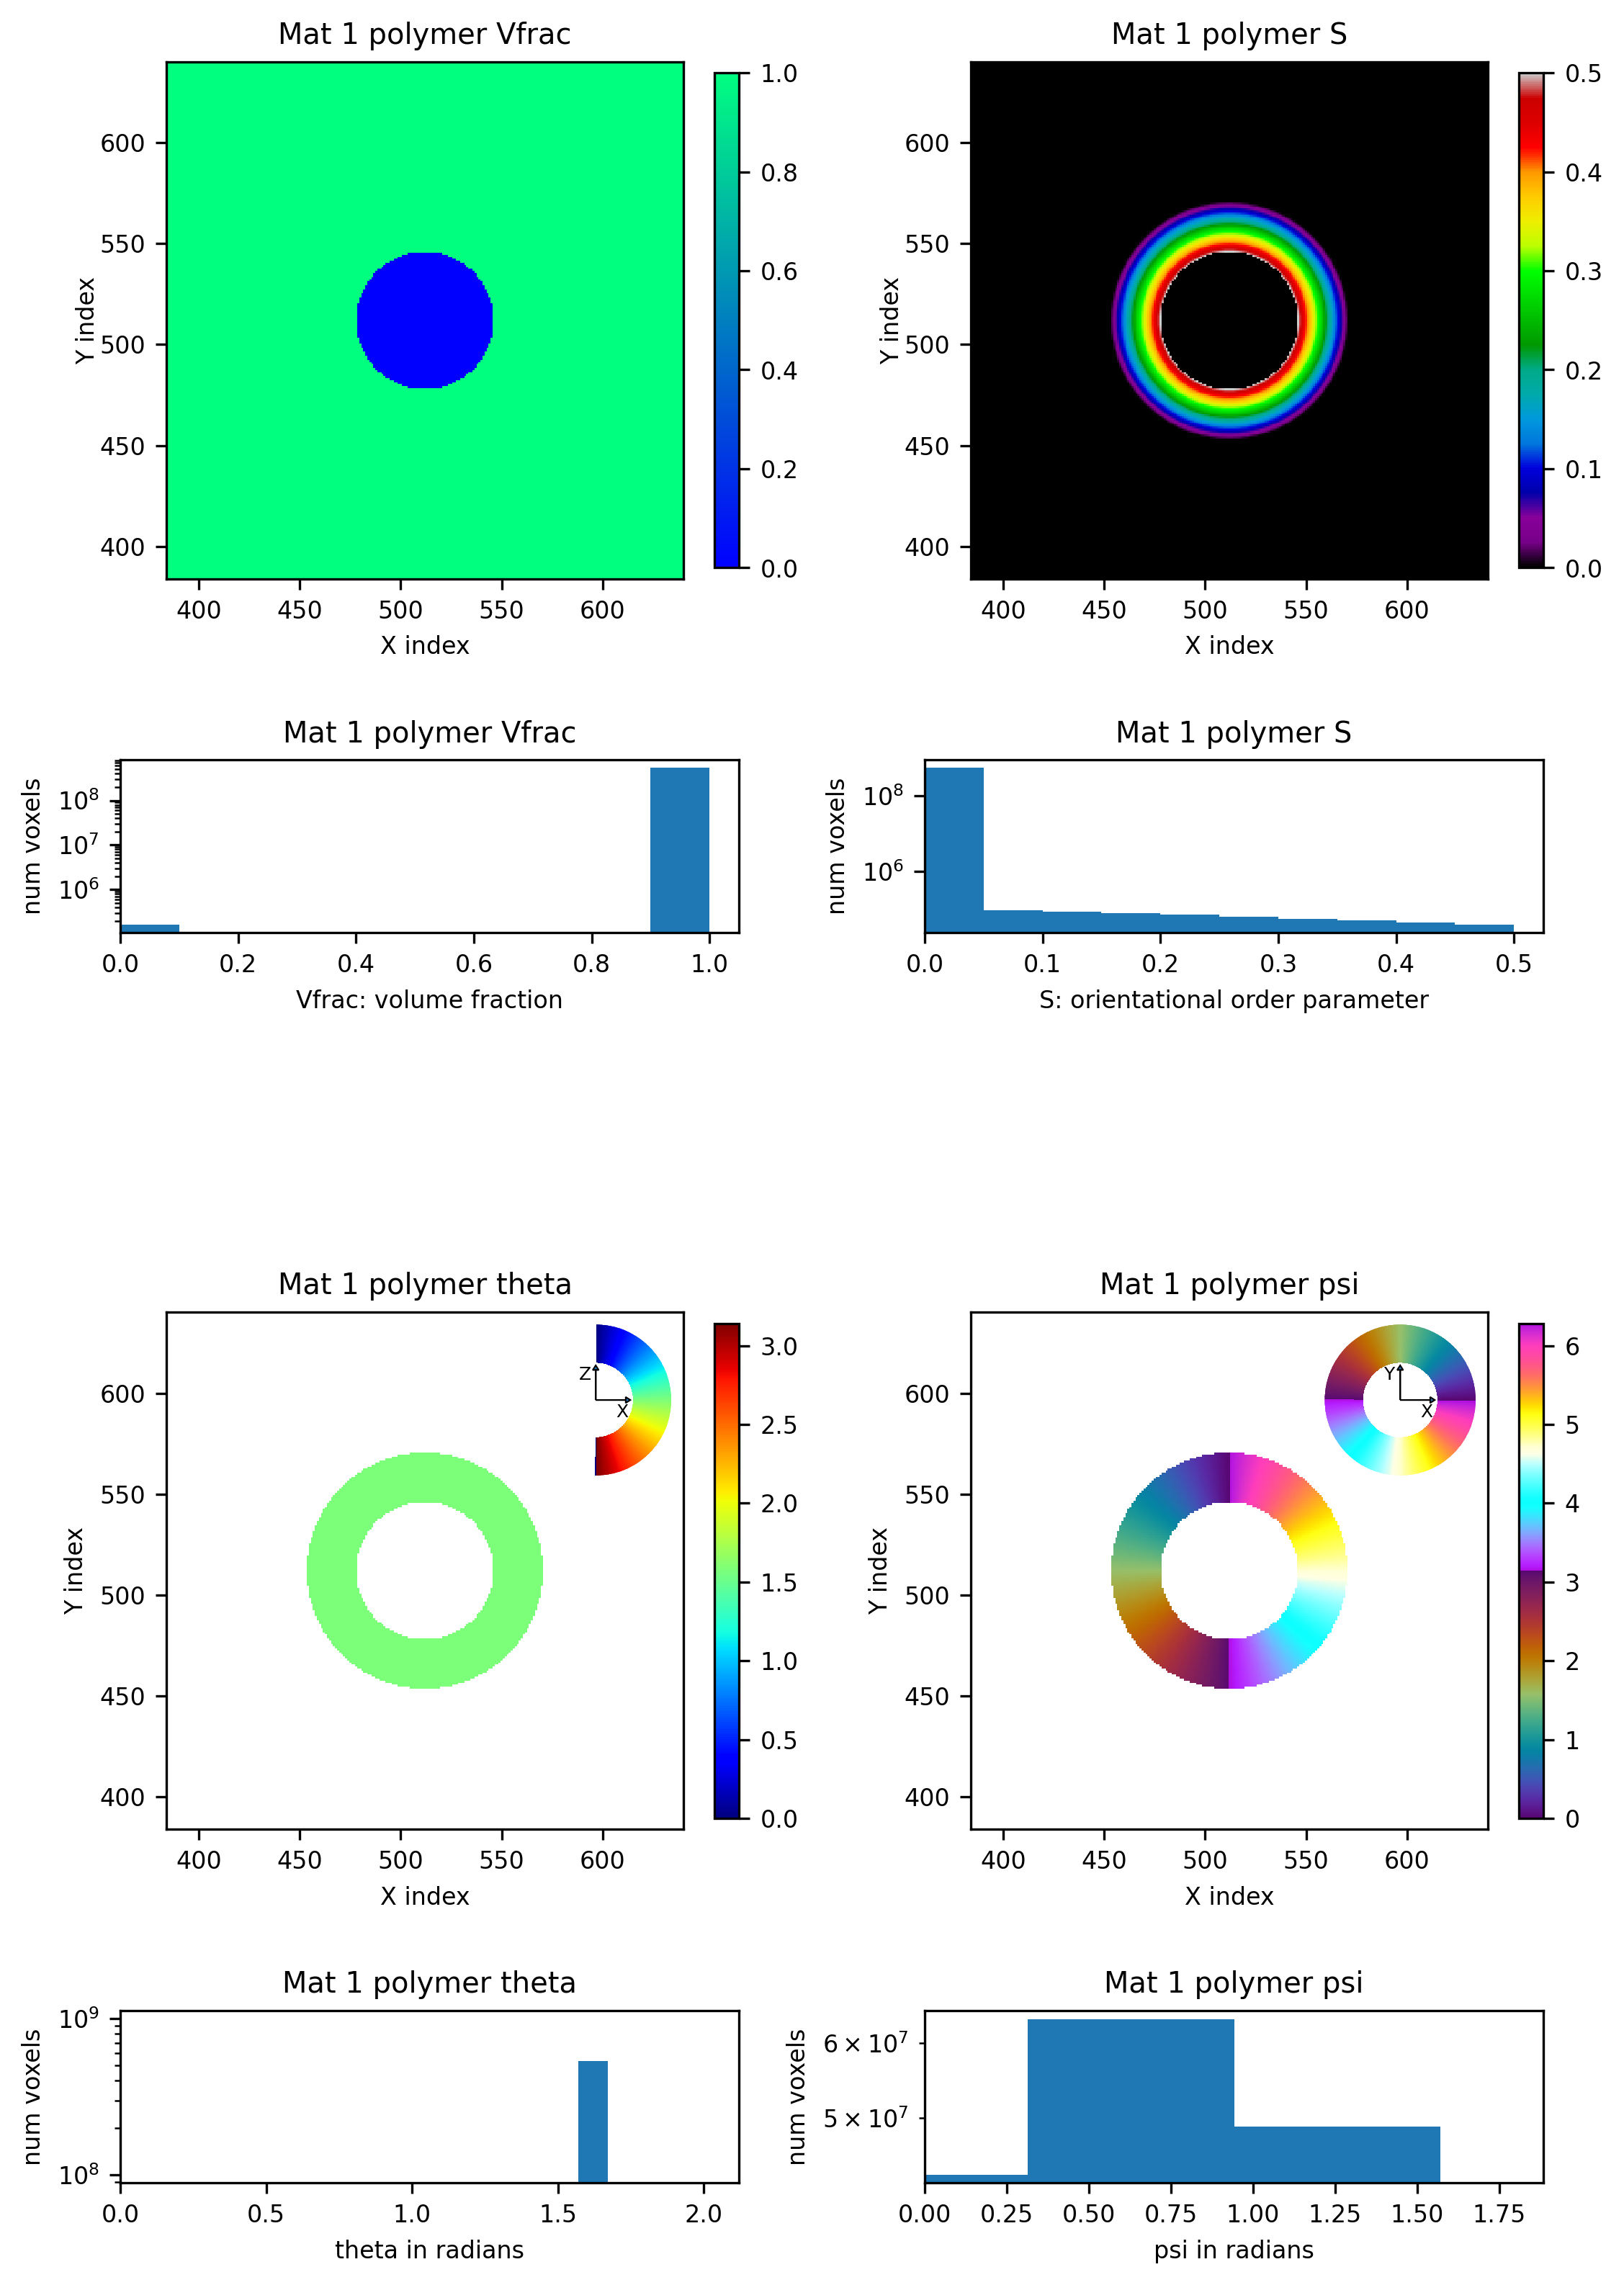

Material 2 Vfrac. Min: 0.0 Max: 1.0
Material 2 S. Min: 0.0 Max: 0.0
Material 2 theta. Min: 0.0 Max: 0.0
Material 2 psi. Min: 0.0 Max: 0.0


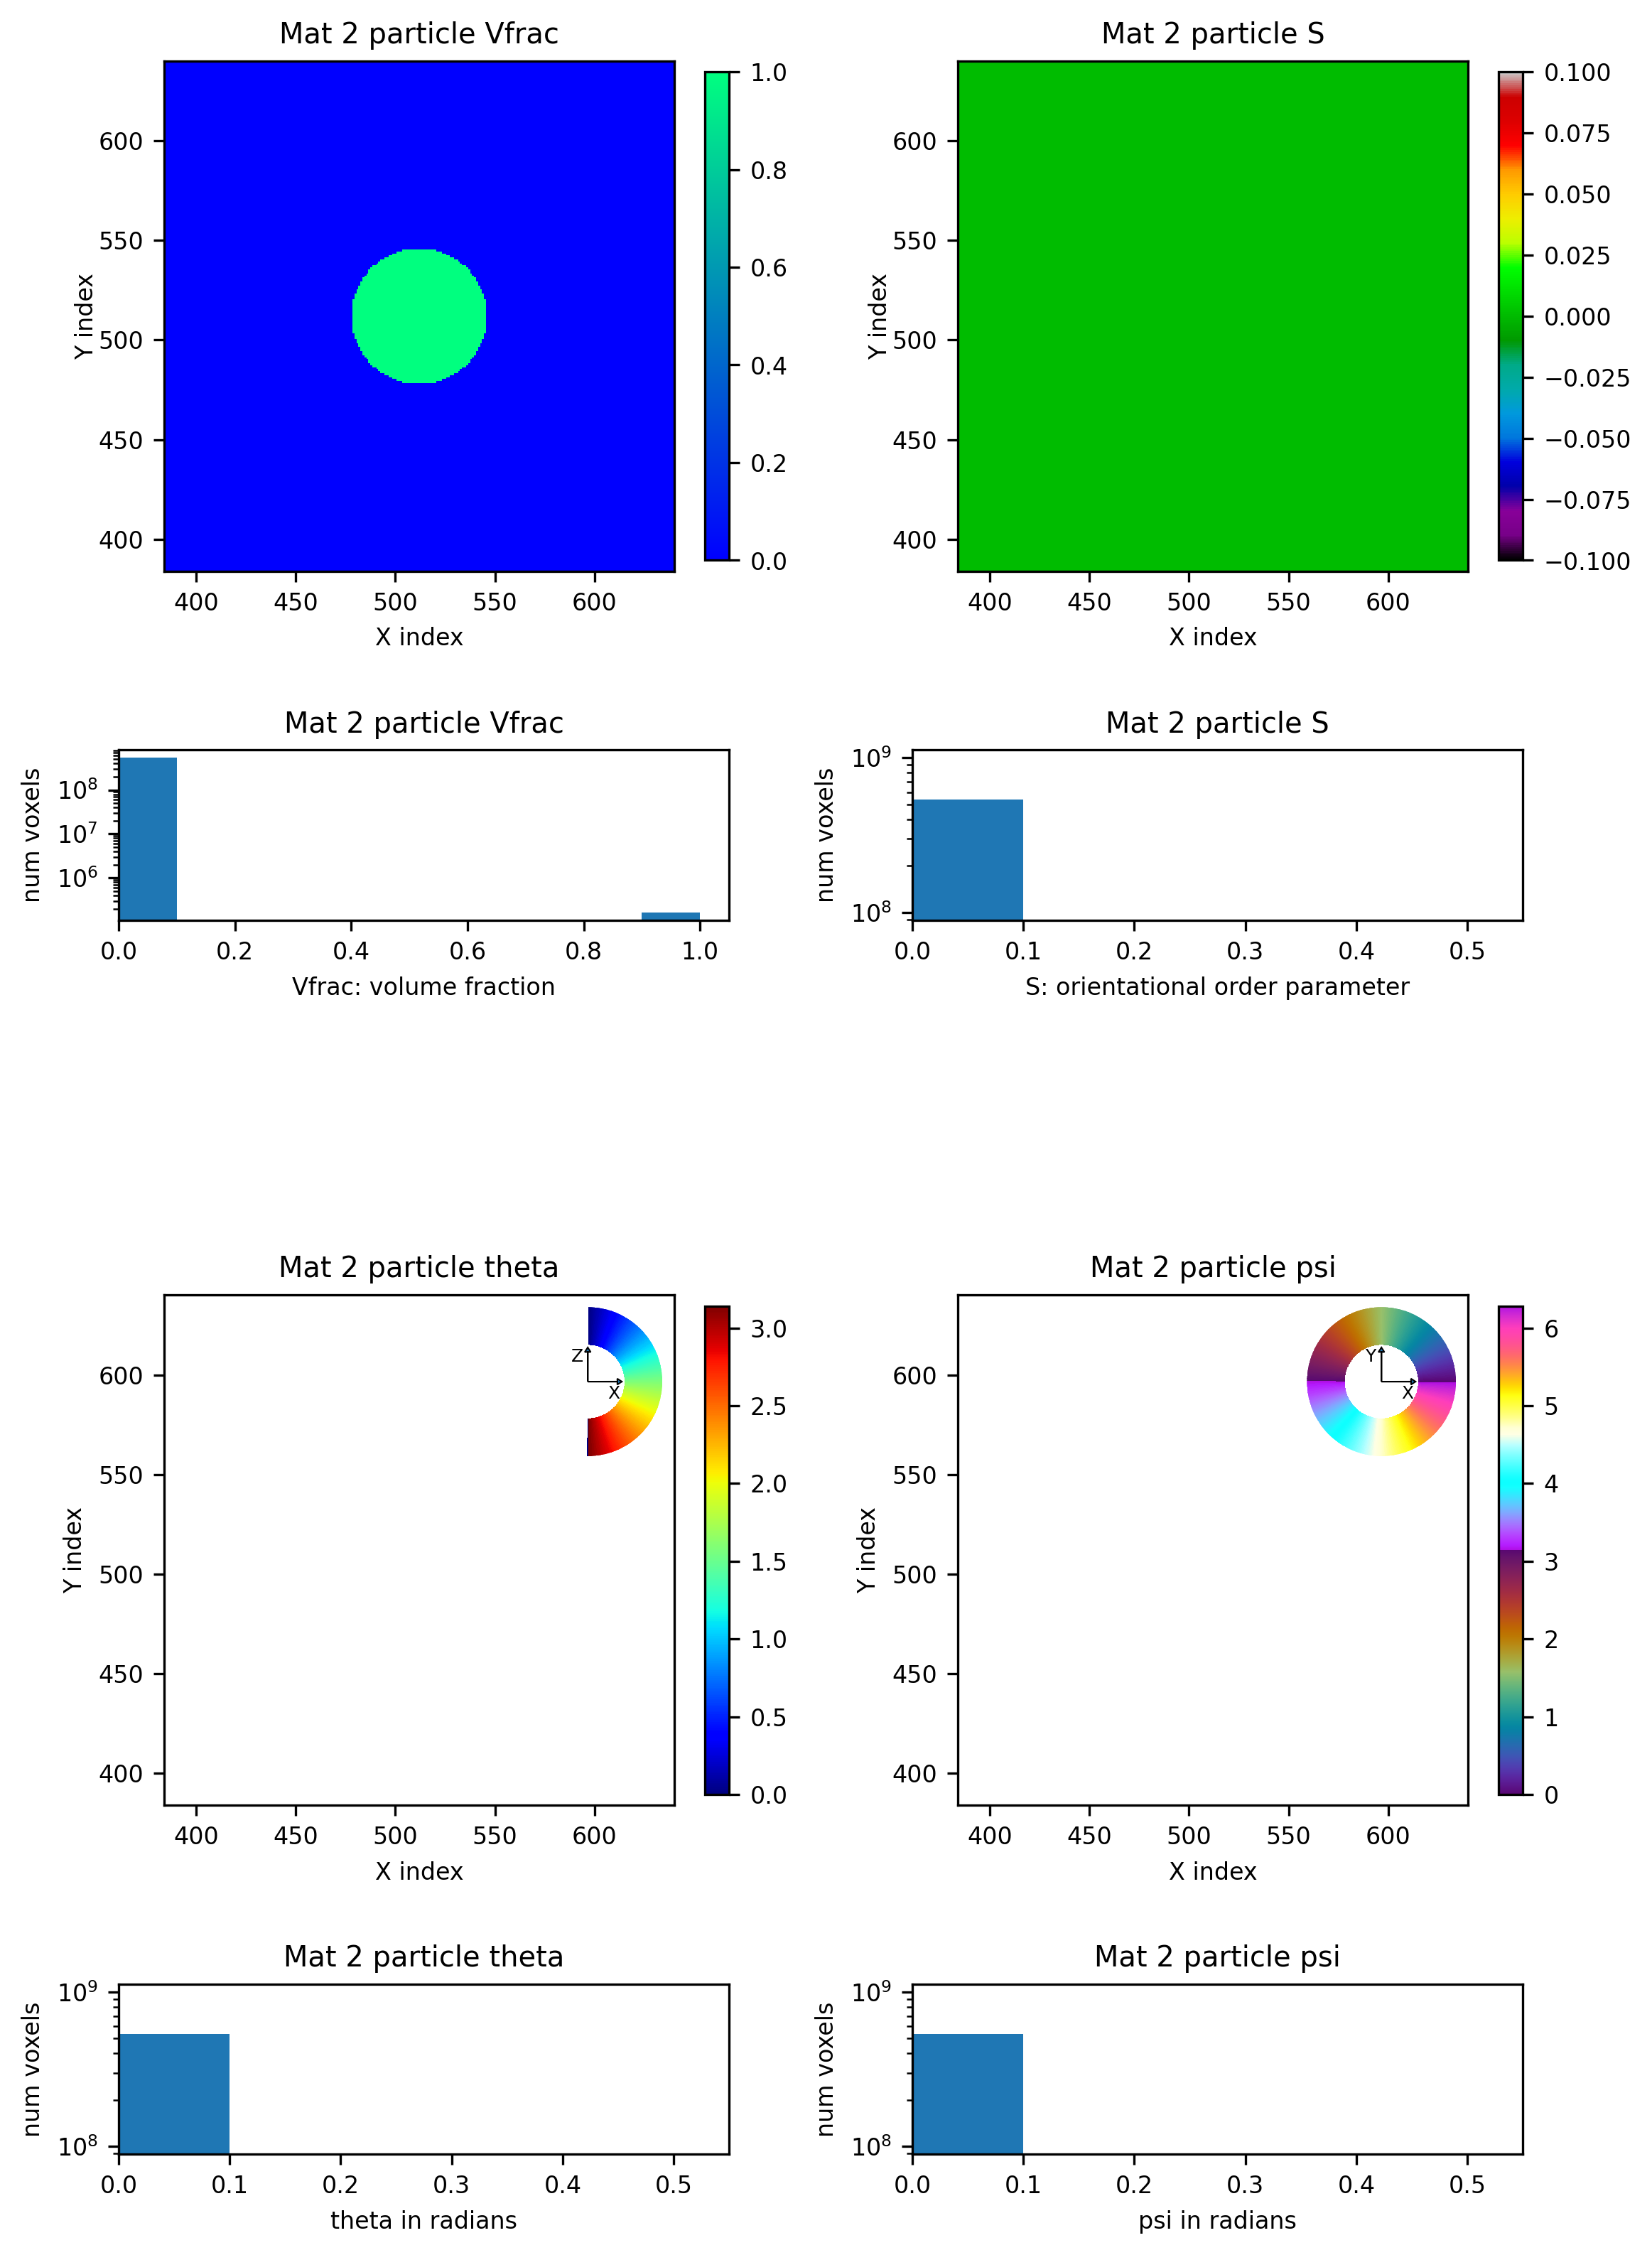

[]

<Figure size 640x480 with 0 Axes>

In [ ]:
morph.visualize_materials(z_slice = args["vd"]//2, subsample = 256)

(-0.5, 987.5, 884.5, -0.5)

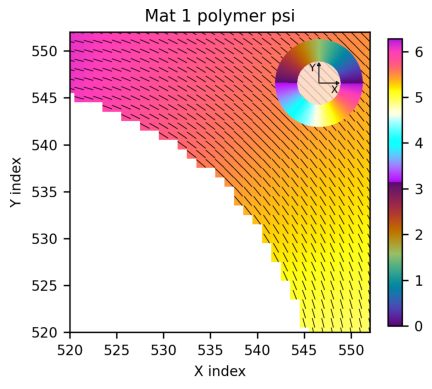

In [ ]:
#always visualize your morphology and understand psi, theta colorwheels
subsample = 32
quiver_psi = morph.visualize_materials(z_slice = args["vd"]//2, subsample = subsample, outputmat = [1], outputplot = ["psi"], add_quiver = True, quiver_bw = "True", runquiet = True, translate_x = subsample//1.3, translate_y = subsample//1.3)[0]
plt.imshow(quiver_psi)
plt.gca().axis("off")

## Run

In [ ]:
morph.inputData.windowingType = 0  # cy.FFTWindowing.Hanning
morph.EAngleRotation = [0.0, 0.0, 0.0]
morph.validate_all(quiet=False)
data = morph.run(stdout=True, stderr=False)
integrator = WPIntegrator(use_chunked_processing=False)
remeshed_data = integrator.integrateImageStack(data)

All material checks have passed
All objects have been validated successfully. You can run your simulation

 [STAT] Executing: 

Number of CUDA devices:1
[INFO] [GPU = Quadro RTX 8000] : 260eV -> 304eV
 [STAT] Energy = 260 starting 
 [STAT] Energy = 270 starting 
 [STAT] Energy = 275 starting 
 [STAT] Energy = 276 starting 
 [STAT] Energy = 277 starting 
 [STAT] Energy = 278 starting 
 [STAT] Energy = 279 starting 
 [STAT] Energy = 280 starting 
 [STAT] Energy = 281 starting 
 [STAT] Energy = 282 starting 
 [STAT] Energy = 283 starting 
 [STAT] Energy = 283.1 starting 
 [STAT] Energy = 283.2 starting 
 [STAT] Energy = 283.3 starting 
 [STAT] Energy = 283.4 starting 
 [STAT] Energy = 283.5 starting 
 [STAT] Energy = 283.6 starting 
 [STAT] Energy = 283.7 starting 
 [STAT] Energy = 283.8 starting 
 [STAT] Energy = 283.9 starting 
 [STAT] Energy = 284 starting 
 [STAT] Energy = 284.1 starting 
 [STAT] Energy = 284.2 starting 
 [STAT] Energy = 284.3 starting 
 [STAT] Energy = 284.4 starting

  0%|          | 0/104 [00:00<?, ?it/s]

## Visualize simulation results

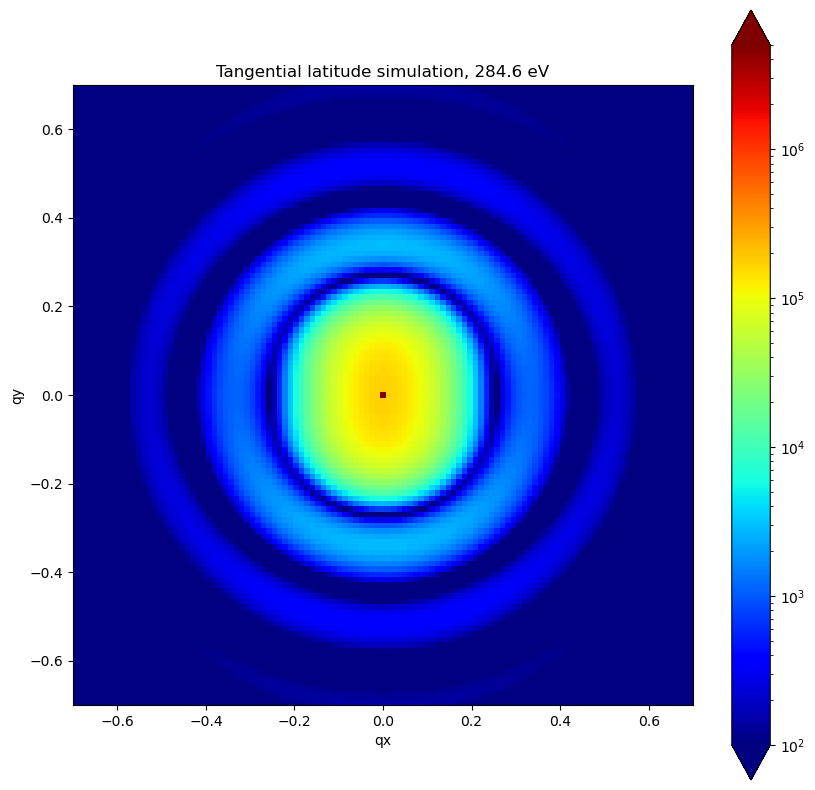

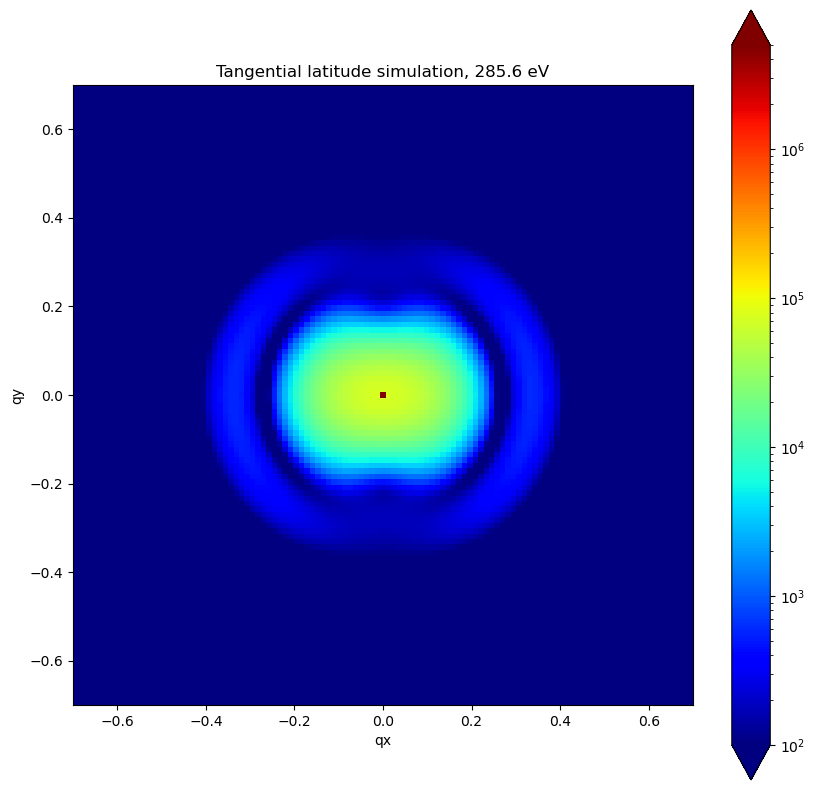

In [ ]:
import matplotlib.colors as colors

for energy in [284.6, 285.6]:
    fig, ax = plt.subplots(figsize = (10,10))
    ax.axes.set_aspect('equal')
    data.sel(energy = energy, method = 'nearest').plot(ax = ax, vmin = 1E2, vmax = 5E6, xlim = (-.7, .7), ylim = (-.7, .7), norm = colors.LogNorm(), cmap = 'jet')
    plt.title(f'Tangential latitude simulation, {energy} eV')
    plt.show()
    plt.close

Text(0.5, 1.0, 'Tangential latitude simulation, A')

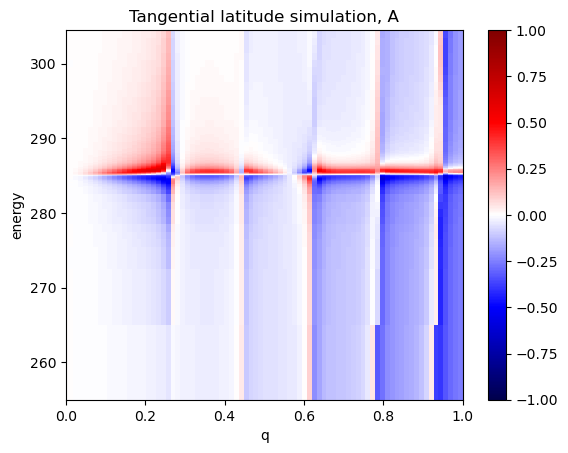

In [ ]:
A = remeshed_data.rsoxs.AR(chi_width = 45)
A.plot(xlim=(0,1.0), vmin = -1, vmax = 1, cmap = 'seismic')
plt.title("Tangential latitude simulation, A")

# Running the model: Longitude Tangential case

## Compose

In [ ]:
mat1_poly = Material(
    materialID=1,
    Vfrac = (1-v_sphere).astype(np.float32), 
    S=S_field.astype(np.float32),
    theta=theta_tangential_lon.astype(np.float32),
    psi=psi_tangential_lon.astype(np.float32),
    NumZYX=v_sphere.shape,
    energies=args["energies"],
    opt_constants=args["oc_polymer"].opt_constants,
    name="polymer",
)

mat2_particle = Material(
    materialID=2,
    Vfrac=v_sphere.astype(np.float32),
    S=a_zeros,
    theta=a_zeros,
    psi=a_zeros,
    NumZYX=v_sphere.shape, 
    energies=args["energies"],
    opt_constants=args["oc_particle"].opt_constants,    
    name="particle",
)

morph = Morphology(
    2,
    {1: mat1_poly, 2: mat2_particle},
    PhysSize=args["PhysSize_nm_per_voxel"],
)

## Visualize

Dataset dimensions (Z, Y, X): 512 x 1024 x 1024
Number of Materials: 2

Material 1 Vfrac. Min: 0.0 Max: 1.0
Material 1 S. Min: 0.0 Max: 0.5
Material 1 theta. Min: 0.0 Max: 3.140211582183838
Material 1 psi. Min: -3.1396396160125732 Max: 3.1415927410125732


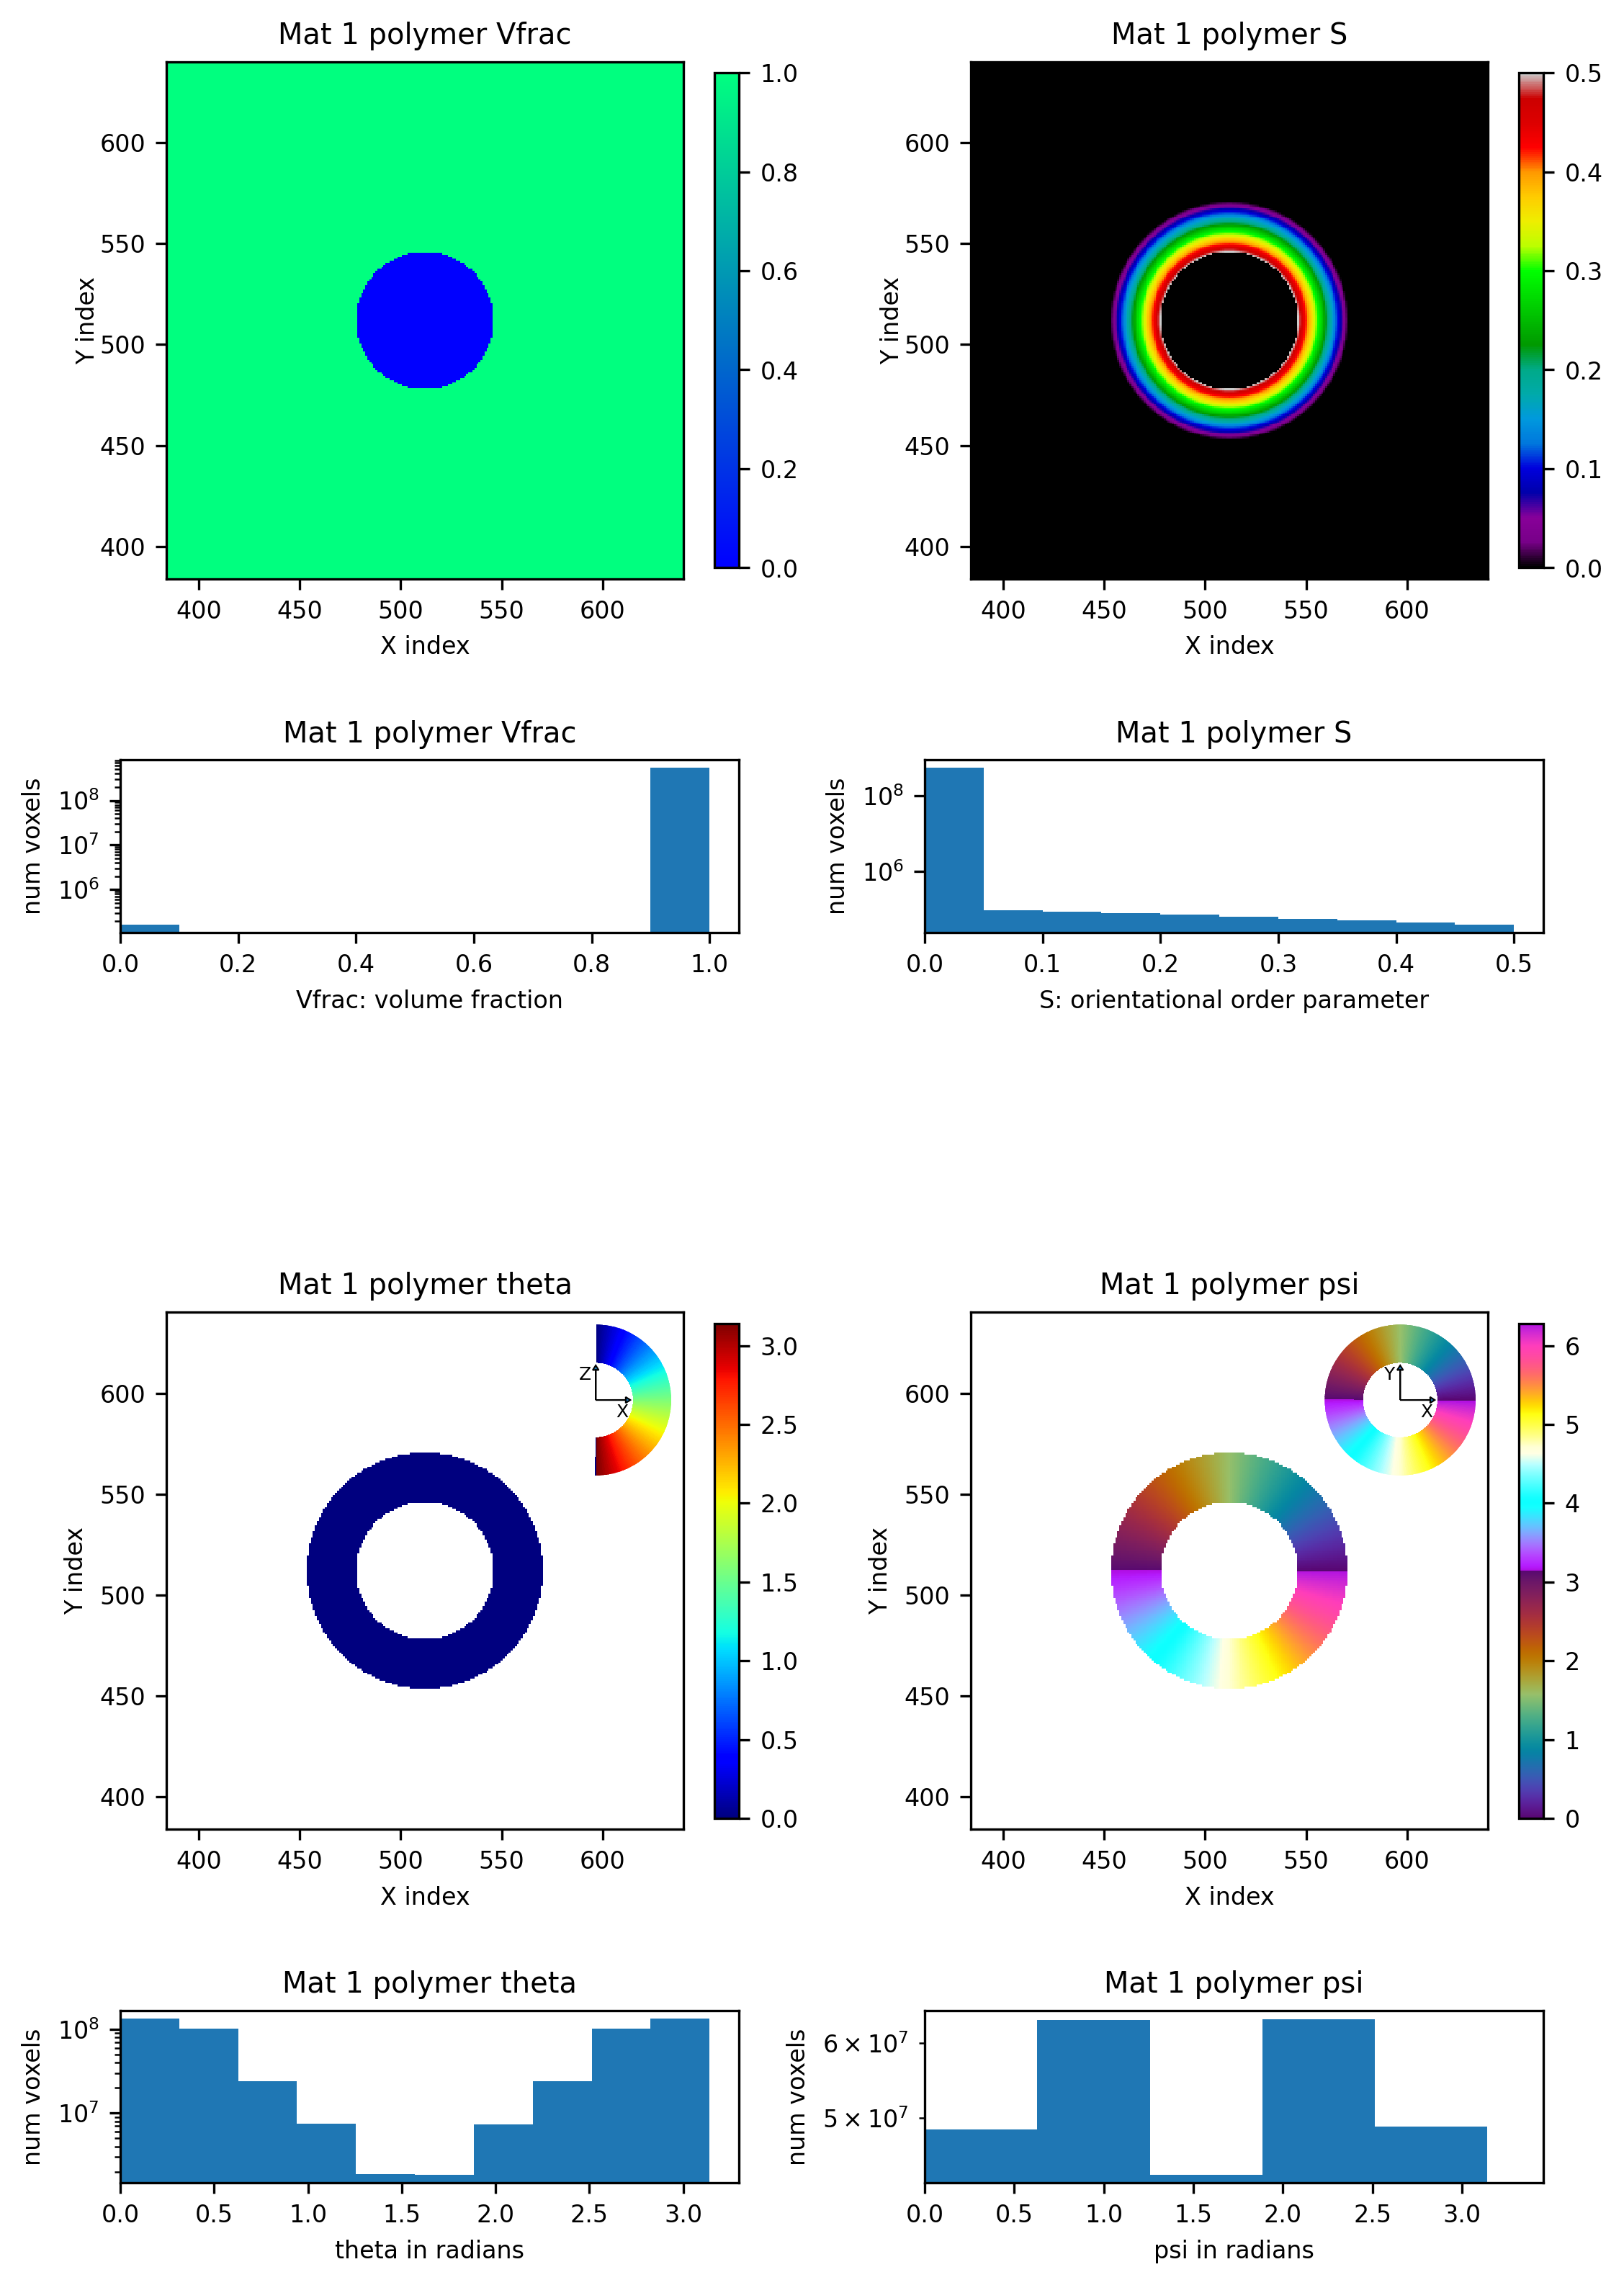

Material 2 Vfrac. Min: 0.0 Max: 1.0
Material 2 S. Min: 0.0 Max: 0.0
Material 2 theta. Min: 0.0 Max: 0.0
Material 2 psi. Min: 0.0 Max: 0.0


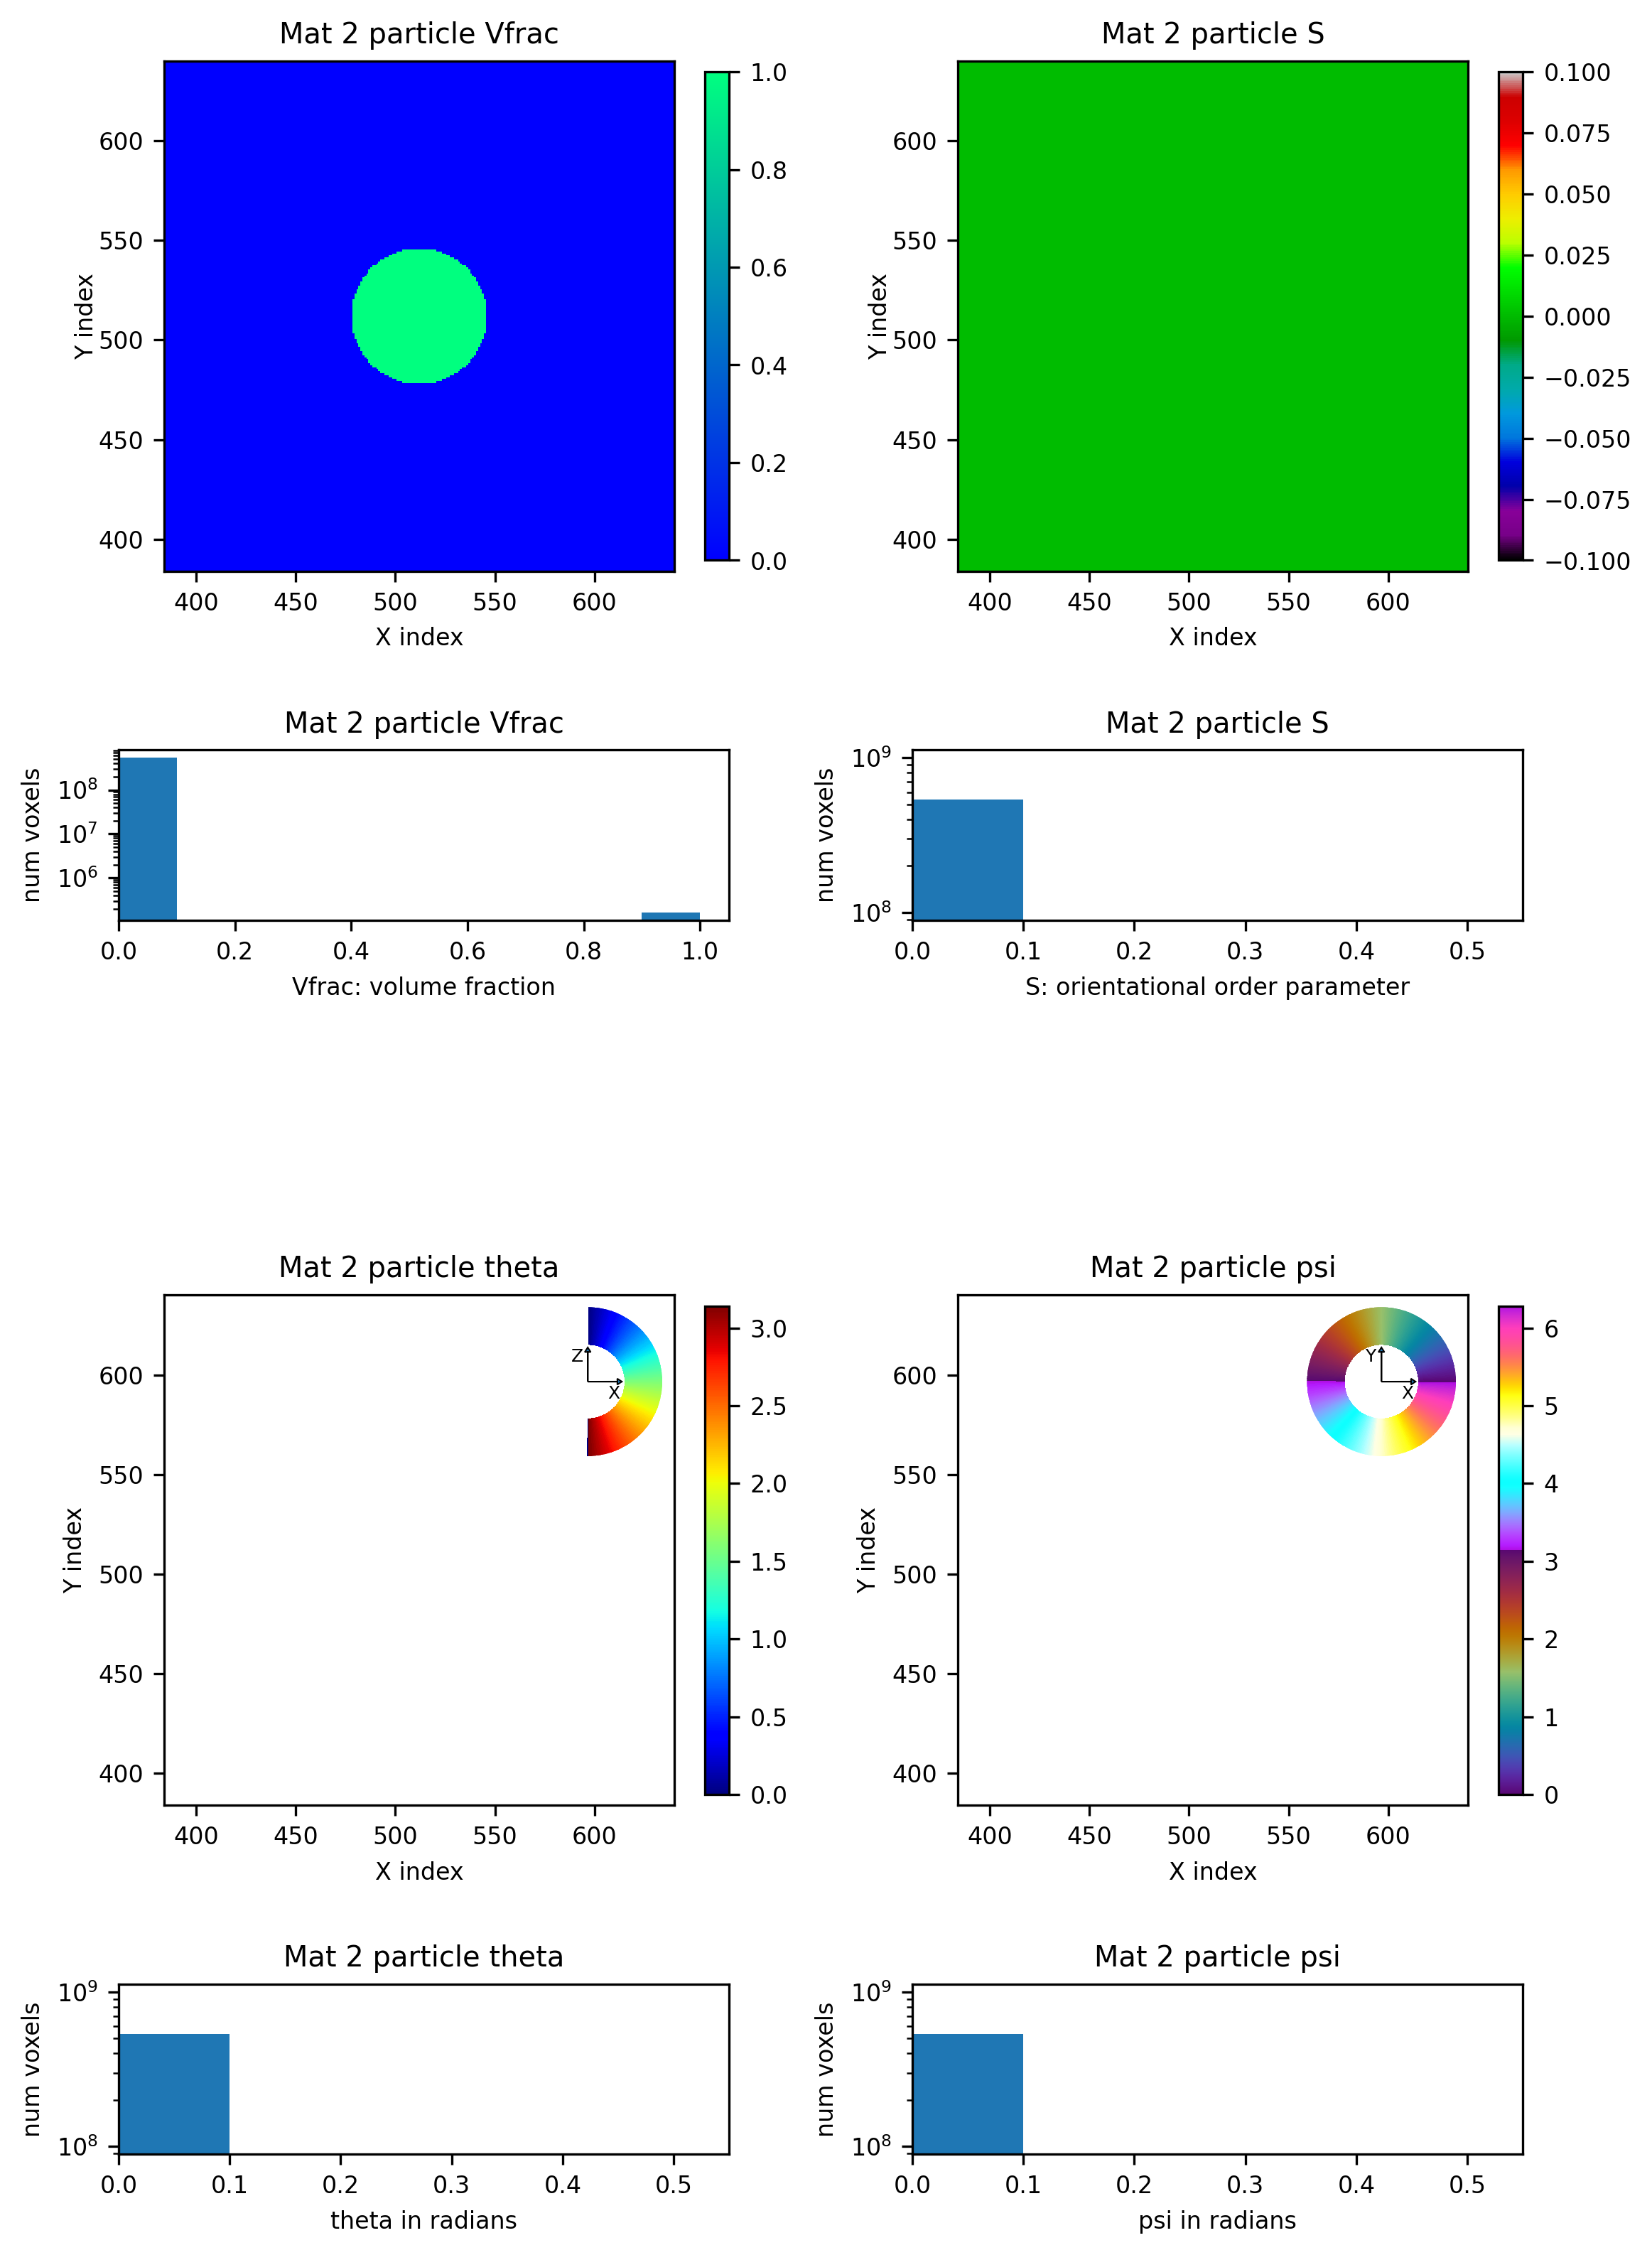

[]

<Figure size 640x480 with 0 Axes>

In [ ]:
morph.visualize_materials(z_slice = args["vd"]//2, subsample = 256)

(-0.5, 987.5, 884.5, -0.5)

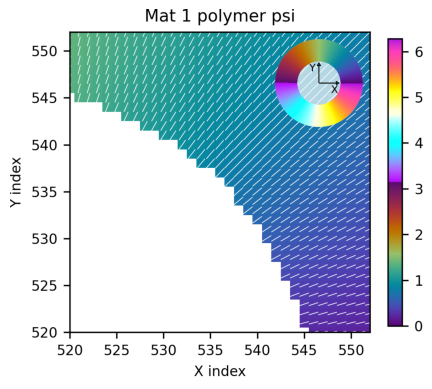

In [ ]:
#always visualize your morphology and understand psi, theta colorwheels
subsample = 32
quiver_psi = morph.visualize_materials(z_slice = args["vd"]//2, subsample = subsample, outputmat = [1], outputplot = ["psi"], add_quiver = True, quiver_bw = "True", runquiet = True, translate_x = subsample//1.3, translate_y = subsample//1.3)[0]
plt.imshow(quiver_psi)
plt.gca().axis("off")

## Run

In [ ]:
morph.inputData.windowingType = 0  # cy.FFTWindowing.Hanning
morph.EAngleRotation = [0.0, 0.0, 0.0]
morph.validate_all(quiet=False)
data = morph.run(stdout=True, stderr=False)
integrator = WPIntegrator(use_chunked_processing=False)
remeshed_data = integrator.integrateImageStack(data)

All material checks have passed
All objects have been validated successfully. You can run your simulation

 [STAT] Executing: 

Number of CUDA devices:1
[INFO] [GPU = Quadro RTX 8000] : 260eV -> 304eV
 [STAT] Energy = 260 starting 
 [STAT] Energy = 270 starting 
 [STAT] Energy = 275 starting 
 [STAT] Energy = 276 starting 
 [STAT] Energy = 277 starting 
 [STAT] Energy = 278 starting 
 [STAT] Energy = 279 starting 
 [STAT] Energy = 280 starting 
 [STAT] Energy = 281 starting 
 [STAT] Energy = 282 starting 
 [STAT] Energy = 283 starting 
 [STAT] Energy = 283.1 starting 
 [STAT] Energy = 283.2 starting 
 [STAT] Energy = 283.3 starting 
 [STAT] Energy = 283.4 starting 
 [STAT] Energy = 283.5 starting 
 [STAT] Energy = 283.6 starting 
 [STAT] Energy = 283.7 starting 
 [STAT] Energy = 283.8 starting 
 [STAT] Energy = 283.9 starting 
 [STAT] Energy = 284 starting 
 [STAT] Energy = 284.1 starting 
 [STAT] Energy = 284.2 starting 
 [STAT] Energy = 284.3 starting 
 [STAT] Energy = 284.4 starting

  0%|          | 0/104 [00:00<?, ?it/s]

## Visualize simulation results

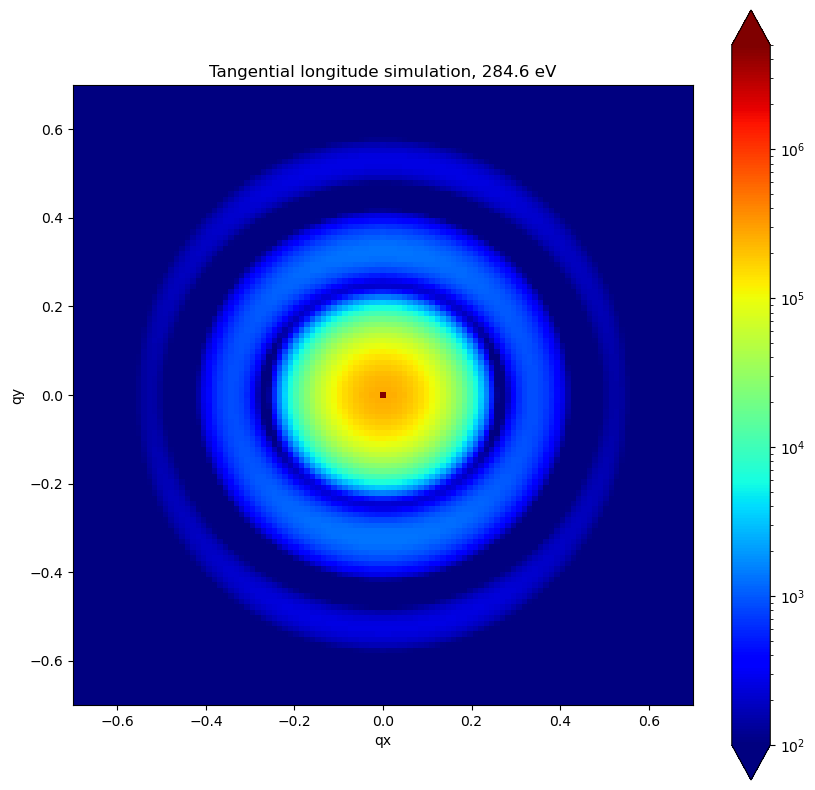

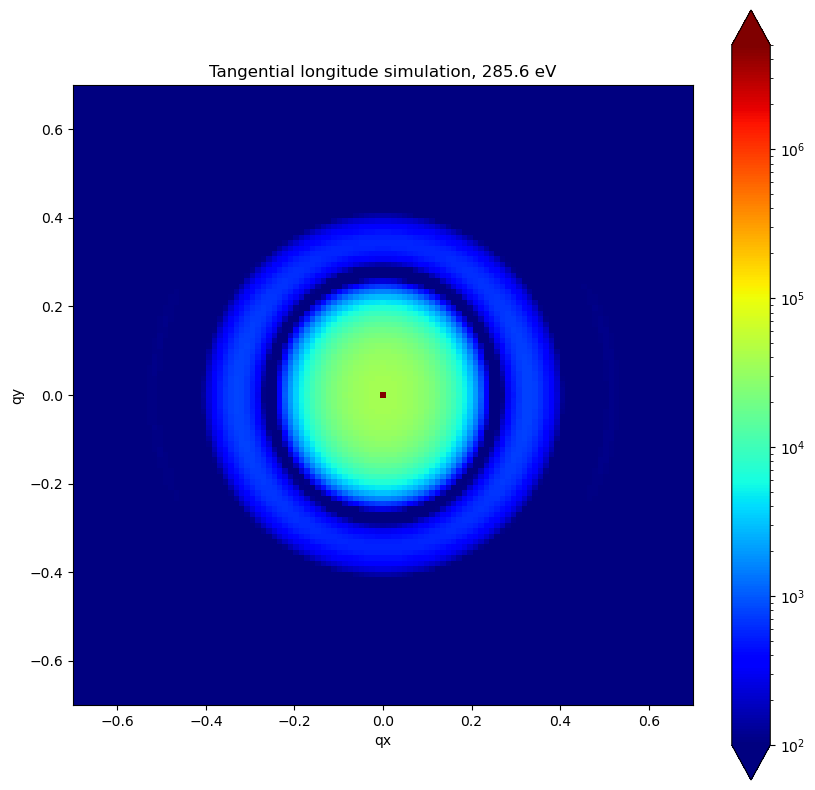

In [ ]:
import matplotlib.colors as colors

for energy in [284.6, 285.6]:
    fig, ax = plt.subplots(figsize = (10,10))
    ax.axes.set_aspect('equal')
    data.sel(energy = energy, method = 'nearest').plot(ax = ax, vmin = 1E2, vmax = 5E6, xlim = (-.7, .7), ylim = (-.7, .7), norm = colors.LogNorm(), cmap = 'jet')
    plt.title(f'Tangential longitude simulation, {energy} eV')
    plt.show()
    plt.close

Text(0.5, 1.0, 'Tangential longitude simulation, A')

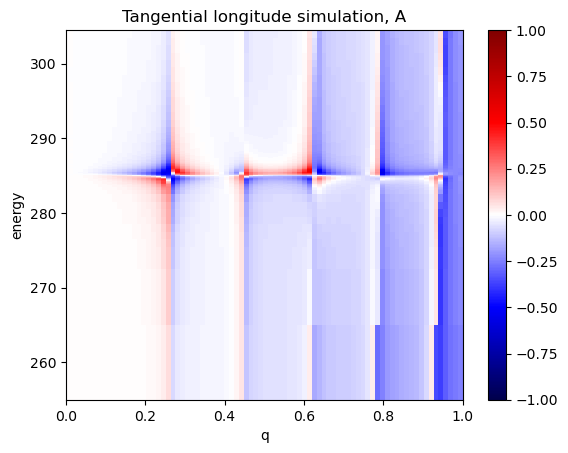

In [ ]:
A = remeshed_data.rsoxs.AR(chi_width = 45)
A.plot(xlim=(0,1.0), vmin = -1, vmax = 1, cmap = 'seismic')
plt.title("Tangential longitude simulation, A")